# Data Collection and Preprocessing

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# 1. Data Collection
# Load the three datasets
print("Loading datasets...")


Loading datasets...


In [3]:
# Total Household Consumption
THC = pd.read_csv("Total Household Consumption subset.csv")
print("THC shape:", THC.shape)
THC.head(2)

THC shape: (9999, 3)


datetime  id  value
0  1604199600   2  0.020
1  1604199600   3  0.039

In [4]:
# Electric Water Heater consumption
EWH = pd.read_csv("Electric Water Heater consumption subset.csv")
print("EWH shape:", EWH.shape)
EWH.head(2)

EWH shape: (9999, 4)


datetime      id  power  voltage
0  1563212254  115609      0        0
1  1563212314  115609      0      222

In [5]:
# Disaggregated Energy Consumption by appliance
DEC = pd.read_csv("Disaggregated Energy Consumption by appliance subset.csv")
print("DEC shape:", DEC.shape)
DEC.head(2)

DEC shape: (144256, 27)


datetime          meter_id  aenergy  aenergy_ph1  aenergy_ph2  \
0  1566943205  00124B0018D6F607      4.0      19830.0          0.0   
1  1566943205  00124B0018D6F752      4.0      29250.0          0.0   

   aenergy_ph3  renergy  renergy_ph1  renergy_ph2  renergy_ph3  ...  \
0          0.0      0.0       4765.0          4.0          0.0  ...   
1          0.0      0.0     111554.0          0.0          1.0  ...   

   current_ph1  current_ph2  current_ph3  pfactor  pfactor_ph1  pfactor_ph2  \
0          1.3          0.0          0.0      0.9          0.9          0.0   
1          1.2          0.0          0.0      0.8          0.8          0.0   

   pfactor_ph3  voltage_ph1  voltage_ph2  voltage_ph3  
0          0.0        223.0          0.0          0.0  
1          0.0        230.0          0.0          0.0  

[2 rows x 27 columns]

In [6]:
# 2. Data Preprocessing

# Function to preprocess a dataset
def preprocess_dataset(df, dataset_name):
    print(f"\nPreprocessing {dataset_name}...")
    
    # a. Initial data exploration
    print("Data types:")
    print(df.dtypes)
    print("\nSummary statistics:")
    print(df.describe())
    
    # b. Handle missing values
    print("\nMissing values before imputation:")
    print(df.isnull().sum())
    
    # Impute missing values with median for numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    imputer = SimpleImputer(strategy='median')
    df[numeric_columns] = imputer.fit_transform(df[numeric_columns])
    
    print("Missing values after imputation:")
    print(df.isnull().sum())
    
    # c. Convert 'datetime' column to datetime type
    if 'datetime' in df.columns:
        df['datetime'] = pd.to_datetime(df['datetime'], unit='s')
    
    # d. Check for and remove duplicates
    duplicates = df.duplicated().sum()
    print(f"\nNumber of duplicates: {duplicates}")
    df.drop_duplicates(inplace=True)
    
    # e. Normalize numerical features (except datetime and id columns)
    columns_to_normalize = df.select_dtypes(include=[np.number]).columns
    columns_to_normalize = columns_to_normalize.drop(['id', 'datetime'], errors='ignore')
    
    scaler = StandardScaler()
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    
    print("\nDataset shape after preprocessing:", df.shape)
    return df

# Preprocess each dataset
THC_processed = preprocess_dataset(THC, "Total Household Consumption")
EWH_processed = preprocess_dataset(EWH, "Electric Water Heater Consumption")
DEC_processed = preprocess_dataset(DEC, "Disaggregated Energy Consumption")

# Additional preprocessing for DEC dataset
if 'meter_id' in DEC_processed.columns:
    print("\nEncoding 'meter_id' in DEC dataset...")
    DEC_processed = pd.get_dummies(DEC_processed, columns=['meter_id'], prefix='meter')



Preprocessing Total Household Consumption...
Data types:
datetime      int64
id            int64
value       float64
dtype: object

Summary statistics:
           datetime           id        value
count  9.999000e+03  9999.000000  9999.000000
mean   1.604296e+09    44.717972     0.056381
std    7.978873e+04    30.443322     0.090737
min    1.604200e+09     2.000000     0.000000
25%    1.604242e+09    19.000000     0.009000
50%    1.604284e+09    41.000000     0.028000
75%    1.604326e+09    70.000000     0.054000
max    1.604682e+09    97.000000     0.997000

Missing values before imputation:
datetime    0
id          0
value       0
dtype: int64
Missing values after imputation:
datetime    0
id          0
value       0
dtype: int64

Number of duplicates: 0

Dataset shape after preprocessing: (9999, 3)

Preprocessing Electric Water Heater Consumption...
Data types:
datetime    int64
id          int64
power       int64
voltage     int64
dtype: object

Summary statistics:
           da

In [7]:
# Save processed datasets
THC_processed.to_csv("THC_processed.csv", index=False)
EWH_processed.to_csv("EWH_processed.csv", index=False)
DEC_processed.to_csv("DEC_processed.csv", index=False)

print("\nPreprocessing complete. Processed datasets saved.")


Preprocessing complete. Processed datasets saved.


# Feature Engineering

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def engineer_features(df, target_column, is_dec=False):
    print(f"Engineering features for dataset with target column: {target_column}\n")
    
    # Store original columns
    original_columns = set(df.columns)
    
    # a. Create time-based features
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['week_of_year'] = df['datetime'].dt.isocalendar().week
    
    # Create 'season' feature (assuming Northern Hemisphere)
    df['season'] = df['month'].map({12:0, 1:0, 2:0,  # Winter
                                    3:1, 4:1, 5:1,  # Spring
                                    6:2, 7:2, 8:2,  # Summer
                                    9:3, 10:3, 11:3})  # Fall
    
    # b. Generate lag features
    for lag in [1, 24, 168]:  # 1 hour, 1 day, 1 week
        df[f'{target_column}_lag_{lag}'] = df[target_column].shift(lag)
    
    # c. Calculate rolling statistics
    for window in [6, 24, 168]:  # 6 hours, 1 day, 1 week
        df[f'{target_column}_rolling_mean_{window}'] = df[target_column].rolling(window=window).mean()
        df[f'{target_column}_rolling_std_{window}'] = df[target_column].rolling(window=window).std()
    
    # d. Create interaction features (example: hour * day_of_week)
    df['hour_day_interaction'] = df['hour'] * df['day_of_week']
    
    # e. Aggregate data at different time scales
    # Daily aggregation
    df[f'{target_column}_daily_mean'] = df.groupby(df['datetime'].dt.date)[target_column].transform('mean')
    df[f'{target_column}_daily_max'] = df.groupby(df['datetime'].dt.date)[target_column].transform('max')
    df[f'{target_column}_daily_min'] = df.groupby(df['datetime'].dt.date)[target_column].transform('min')
    
    # Weekly aggregation
    df[f'{target_column}_weekly_mean'] = df.groupby(df['datetime'].dt.to_period('W'))[target_column].transform('mean')
    df[f'{target_column}_weekly_max'] = df.groupby(df['datetime'].dt.to_period('W'))[target_column].transform('max')
    df[f'{target_column}_weekly_min'] = df.groupby(df['datetime'].dt.to_period('W'))[target_column].transform('min')
    
    if is_dec:
        # Add the four new columns for DEC dataset
        df['total_energy'] = df['aenergy'] + df['renergy']
        df['pf_ratio'] = df['pfactor'] / df[['pfactor_ph1', 'pfactor_ph2', 'pfactor_ph3']].mean(axis=1)
        df['voltage_imbalance'] = df[['voltage_ph1', 'voltage_ph2', 'voltage_ph3']].std(axis=1) / df[['voltage_ph1', 'voltage_ph2', 'voltage_ph3']].mean(axis=1)
        df['current_imbalance'] = df[['current_ph1', 'current_ph2', 'current_ph3']].std(axis=1) / df[['current_ph1', 'current_ph2', 'current_ph3']].mean(axis=1)
    
    # Drop rows with NaN values created by lag and rolling features
    df.dropna(inplace=True)
    
    # Normalize new numerical features
    scaler = StandardScaler()
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
    
    print(f"Shape after feature engineering: {df.shape}\n")
    
    # Get new features
    new_features = set(df.columns) - original_columns
    print("New features:")
    for feature in sorted(new_features):
        print(feature)
    
    return df

# Load the preprocessed datasets
THC = pd.read_csv("THC_processed.csv")
EWH = pd.read_csv("EWH_processed.csv")
DEC = pd.read_csv("DEC_processed.csv")

# Ensure datetime is in the correct format
for df in [THC, EWH, DEC]:
    df['datetime'] = pd.to_datetime(df['datetime'])

# Apply feature engineering to each dataset
THC_featured = engineer_features(THC, 'value')
EWH_featured = engineer_features(EWH, 'power')
DEC_featured = engineer_features(DEC, 'apower', is_dec=True)

# Save featured dataframes
THC_featured.to_csv("THC_featured.csv", index=False)
EWH_featured.to_csv("EWH_featured.csv", index=False)
DEC_featured.to_csv("DEC_featured.csv", index=False)
print("\nFeatured dataframes have been saved.")

Engineering features for dataset with target column: value

Shape after feature engineering: (9831, 25)

New features:
day_of_week
day_of_year
hour
hour_day_interaction
month
season
value_daily_max
value_daily_mean
value_daily_min
value_lag_1
value_lag_168
value_lag_24
value_rolling_mean_168
value_rolling_mean_24
value_rolling_mean_6
value_rolling_std_168
value_rolling_std_24
value_rolling_std_6
value_weekly_max
value_weekly_mean
value_weekly_min
week_of_year
Engineering features for dataset with target column: power

Shape after feature engineering: (9831, 26)

New features:
day_of_week
day_of_year
hour
hour_day_interaction
month
power_daily_max
power_daily_mean
power_daily_min
power_lag_1
power_lag_168
power_lag_24
power_rolling_mean_168
power_rolling_mean_24
power_rolling_mean_6
power_rolling_std_168
power_rolling_std_24
power_rolling_std_6
power_weekly_max
power_weekly_mean
power_weekly_min
season
week_of_year
Engineering features for dataset with target column: apower

Shape after

# Exploratory Data Analysis (EDA)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

# Load the feature-engineered datasets
THC = pd.read_csv("THC_featured.csv")
EWH = pd.read_csv("EWH_featured.csv")
DEC = pd.read_csv("DEC_featured.csv")

# Ensure datetime is in the correct format
for df in [THC, EWH, DEC]:
    df['datetime'] = pd.to_datetime(df['datetime'])

def perform_eda(df, dataset_name, target_column):
    print(f"\nPerforming EDA on {dataset_name} dataset")
    
    # 1. Basic statistics
    print("\nBasic statistics:")
    print(df.describe())
    
    # 2. Check for missing values
    print("\nMissing values:")
    print(df.isnull().sum())
    
    # 3. Visualize time series patterns
    plt.figure(figsize=(12, 6))
    plt.plot(df['datetime'], df[target_column])
    plt.title(f'{dataset_name} - {target_column} Over Time')
    plt.xlabel('Date')
    plt.ylabel(target_column)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 4. Analyze correlations
    plt.figure(figsize=(12, 10))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title(f'{dataset_name} - Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    
    # Print top 5 correlations with target variable
    top_correlations = correlation_matrix[target_column].sort_values(ascending=False)[:6]
    print(f"\nTop 5 correlations with {target_column}:")
    print(top_correlations)
    
    # 5. Seasonal patterns
    plt.figure(figsize=(12, 6))
    df.groupby('month')[target_column].mean().plot(kind='bar')
    plt.title(f'{dataset_name} - Average {target_column} by Month')
    plt.xlabel('Month')
    plt.ylabel(f'Average {target_column}')
    plt.tight_layout()
    plt.show()
    
    # 6. Distribution of target variable
    plt.figure(figsize=(10, 6))
    sns.histplot(df[target_column], kde=True)
    plt.title(f'{dataset_name} - Distribution of {target_column}')
    plt.xlabel(target_column)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
    # 7. Box plot for hourly patterns
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='hour', y=target_column, data=df)
    plt.title(f'{dataset_name} - {target_column} Distribution by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel(target_column)
    plt.tight_layout()
    plt.show()
    
    # 8. Scatter plot of two most correlated features
    if len(top_correlations) >= 3:
        feature1, feature2 = top_correlations.index[1], top_correlations.index[2]
        plt.figure(figsize=(10, 6))
        plt.scatter(df[feature1], df[feature2], alpha=0.5)
        plt.title(f'{dataset_name} - {feature1} vs {feature2}')
        plt.xlabel(feature1)
        plt.ylabel(feature2)
        plt.tight_layout()
        plt.show()
    
    # 9. Check for outliers using Z-score
    z_scores = np.abs(stats.zscore(df[target_column]))
    outliers = (z_scores > 3).sum()
    print(f"\nNumber of outliers in {target_column} (based on Z-score > 3): {outliers}")
    
    # 10. Autocorrelation plot
    from pandas.plotting import autocorrelation_plot
    plt.figure(figsize=(12, 6))
    autocorrelation_plot(df[target_column])
    plt.title(f'{dataset_name} - Autocorrelation Plot for {target_column}')
    plt.tight_layout()
    plt.show()



Performing EDA on Total Household Consumption dataset

Basic statistics:
                            datetime            id        value          hour  \
count                           9831  9.831000e+03  9831.000000  9.831000e+03   
mean   2020-11-02 06:17:40.939884032  7.516676e-17     0.000000  6.938470e-17   
min              2020-11-01 03:00:00 -1.434685e+00    -0.625384 -1.822260e+00   
25%              2020-11-01 15:15:00 -8.396162e-01    -0.526489 -8.752223e-01   
50%              2020-11-02 02:45:00 -1.453691e-01    -0.317710  7.181534e-02   
75%              2020-11-02 14:30:00  8.133530e-01    -0.021025  8.610134e-01   
max              2020-11-06 17:00:00  1.705956e+00    10.330002  1.808051e+00   
std                              NaN  1.000051e+00     1.000051  1.000051e+00   

        day_of_week   month   day_of_year  week_of_year  season   value_lag_1  \
count  9.831000e+03  9831.0  9.831000e+03  9.831000e+03  9831.0  9.831000e+03   
mean   3.931800e-16     0.0 -3.723

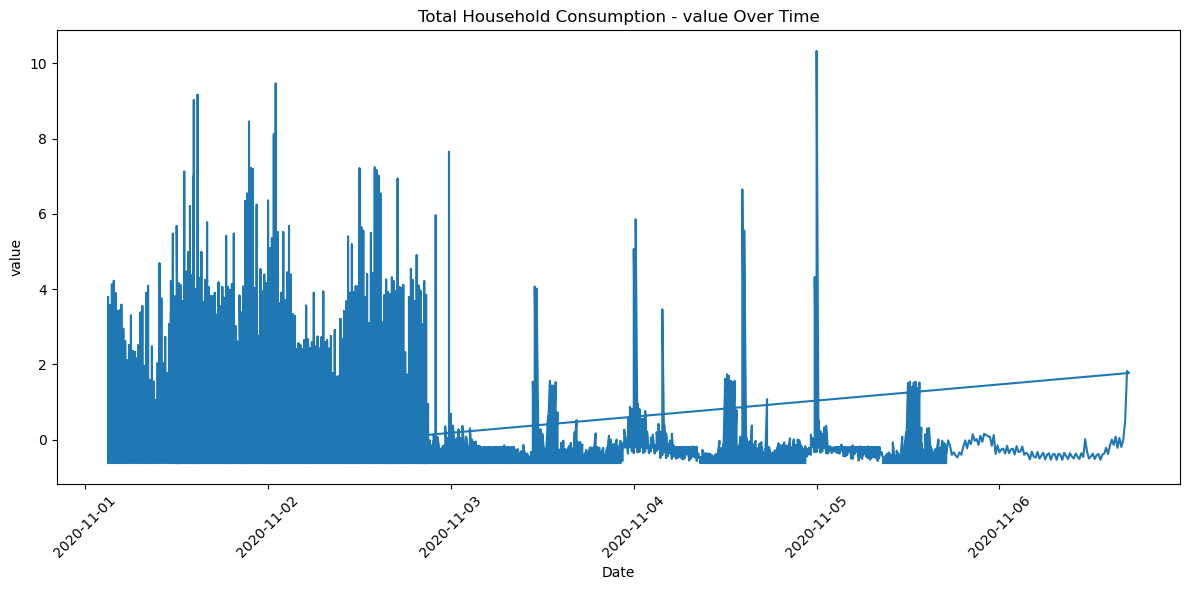

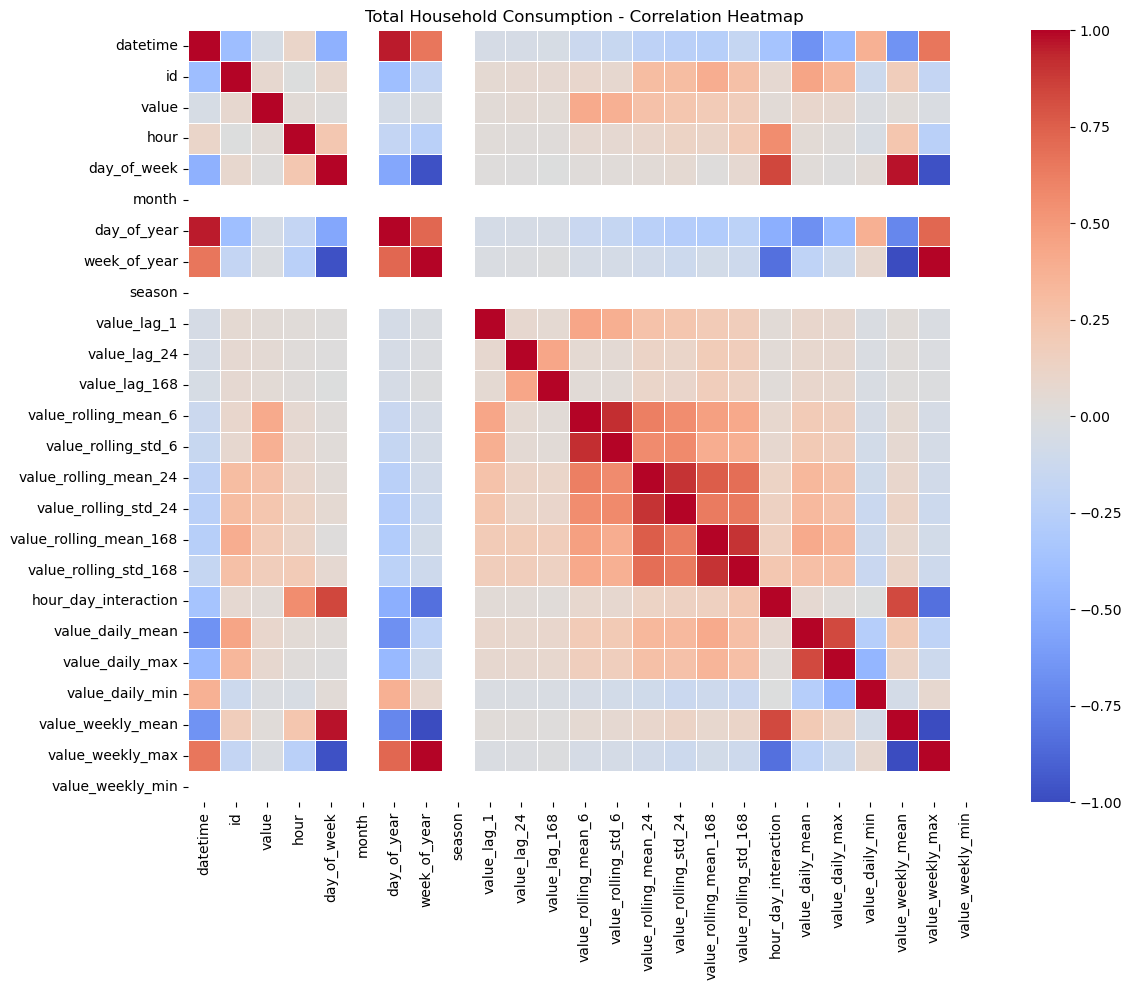


Top 5 correlations with value:
value                     1.000000
value_rolling_mean_6      0.410158
value_rolling_std_6       0.379758
value_rolling_mean_24     0.269948
value_rolling_std_24      0.236332
value_rolling_mean_168    0.199286
Name: value, dtype: float64


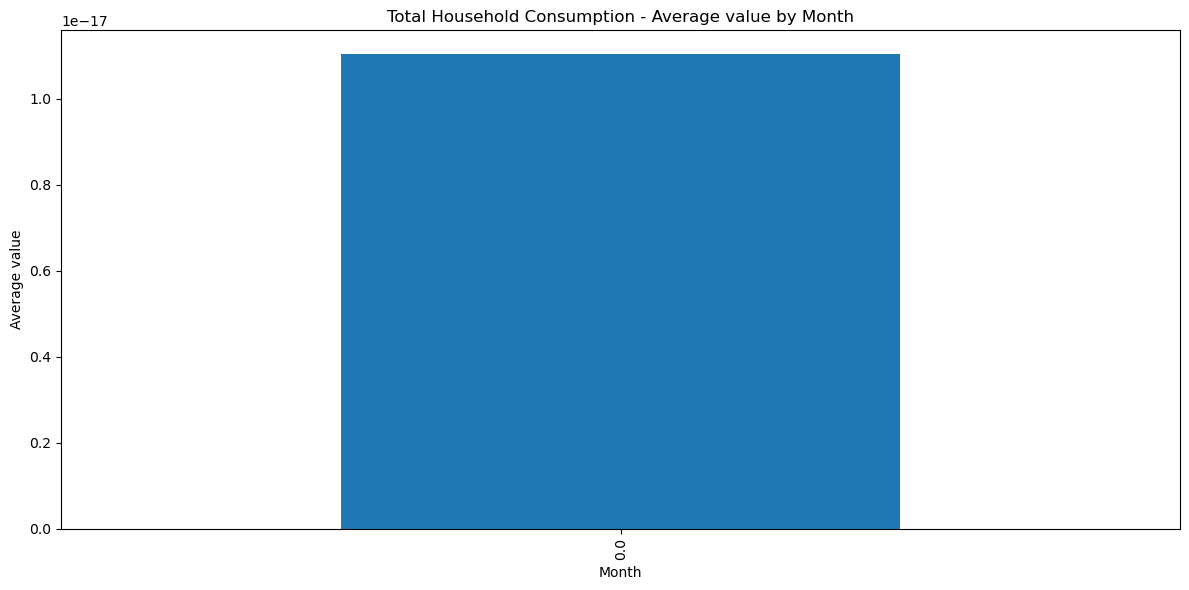

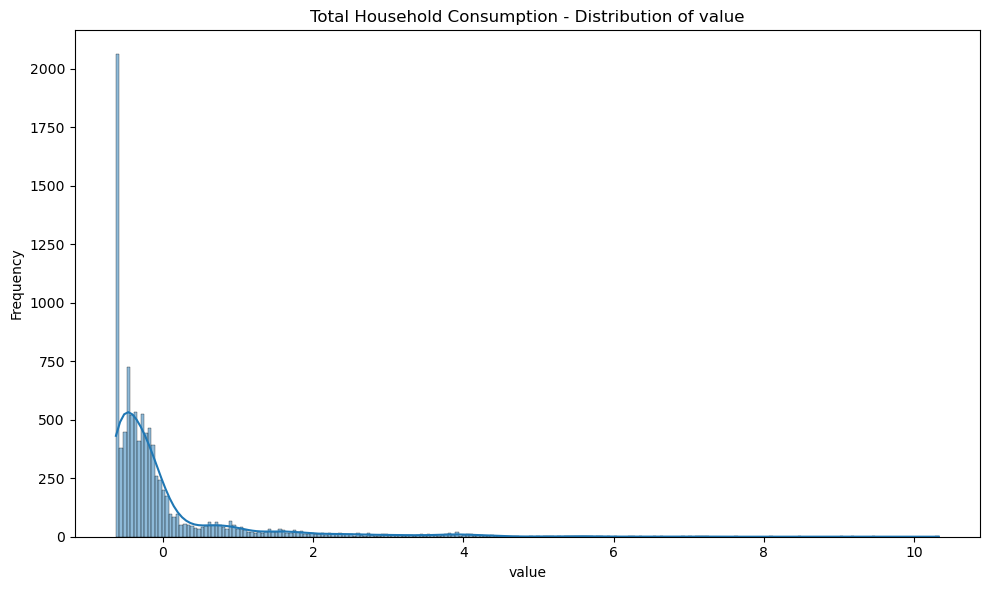

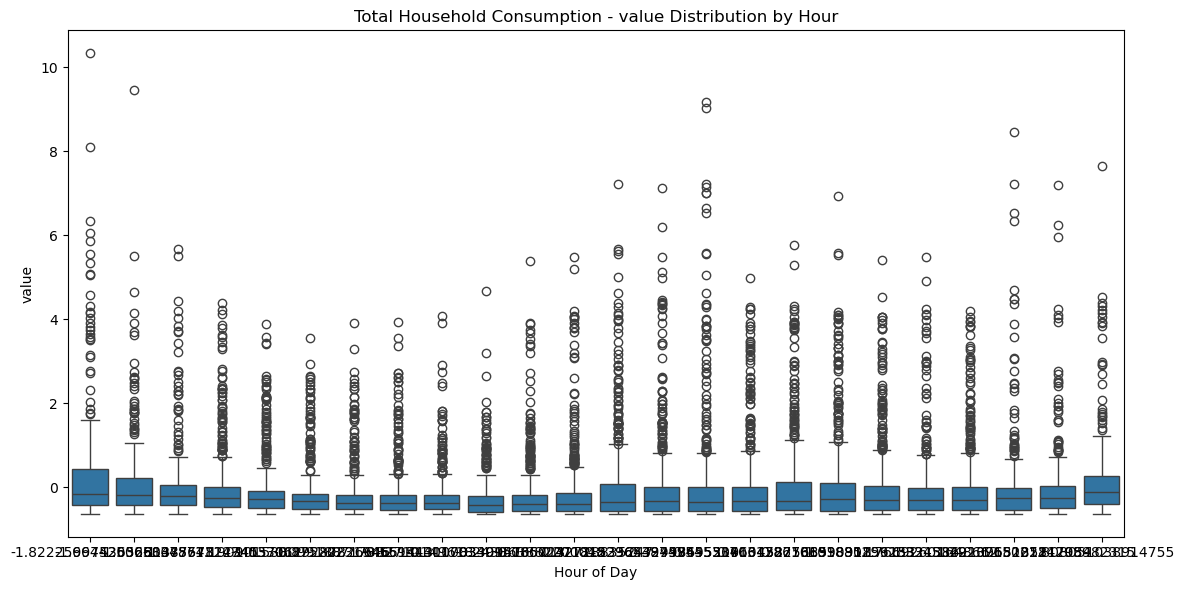

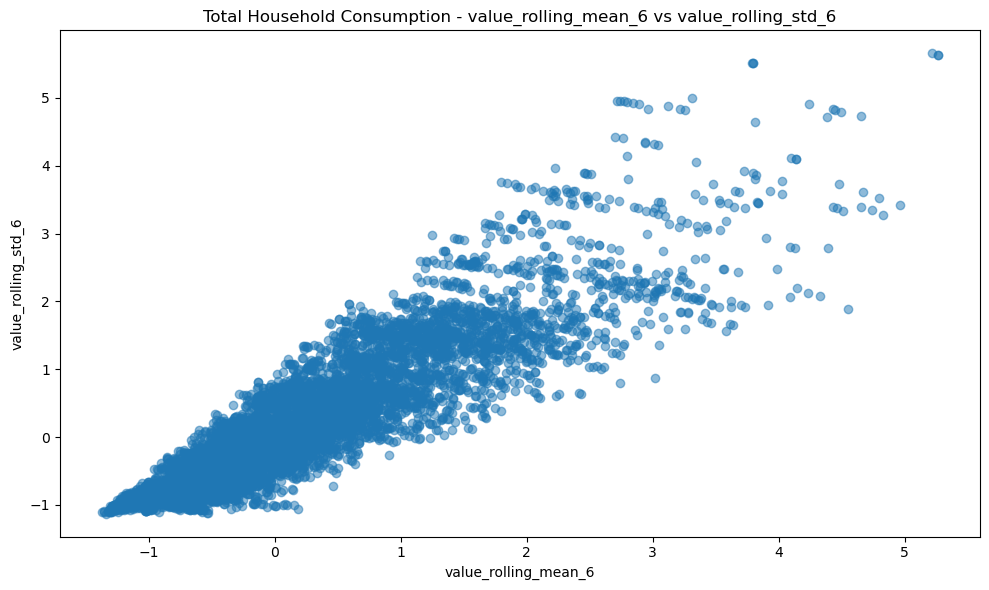


Number of outliers in value (based on Z-score > 3): 291


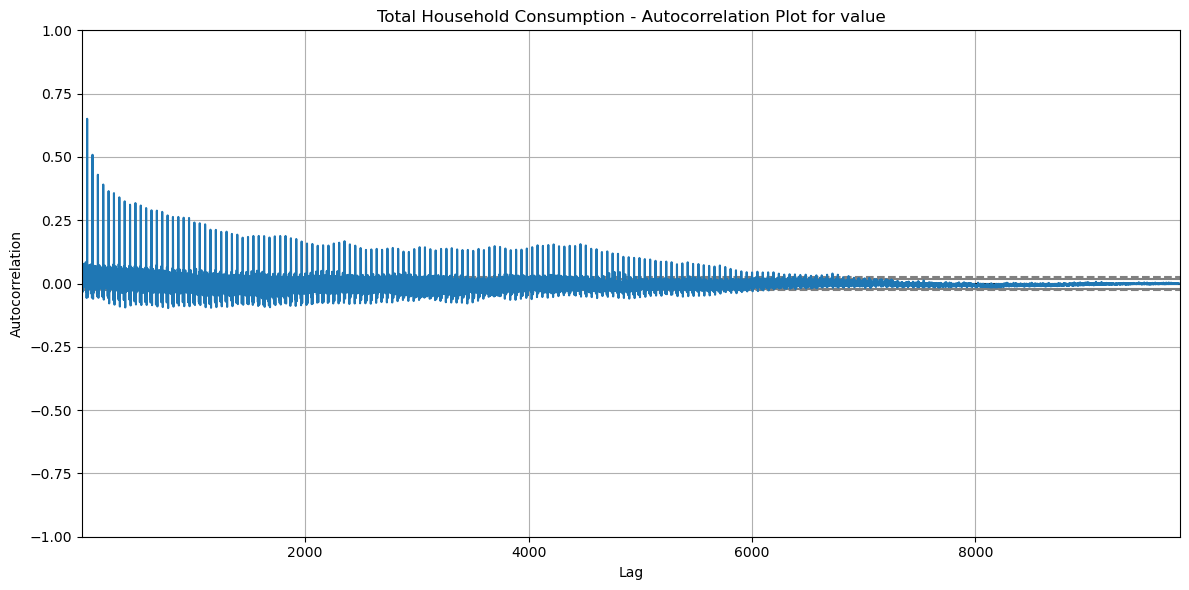

In [12]:
# Perform EDA on Total Household Consumption dataset
perform_eda(THC, "Total Household Consumption", "value")



Performing EDA on Electric Water Heater dataset

Basic statistics:
                            datetime            id         power  \
count                           9831  9.831000e+03  9.831000e+03   
mean   2019-07-19 04:57:51.068253696  6.579983e-15  8.239434e-17   
min              2019-07-15 19:10:39 -4.626741e-02 -4.466264e-01   
25%       2019-07-17 11:53:54.500000 -4.626741e-02 -4.466264e-01   
50%              2019-07-19 04:56:54 -4.626741e-02 -4.466264e-01   
75%              2019-07-20 22:02:14 -4.626741e-02 -4.466264e-01   
max              2019-07-22 15:06:58  2.161349e+01  2.522733e+00   
std                              NaN  1.000051e+00  1.000051e+00   

            voltage          hour   day_of_week   month   day_of_year  \
count  9.831000e+03  9.831000e+03  9.831000e+03  9831.0  9.831000e+03   
mean  -2.457375e-17 -3.180132e-17 -1.387694e-16     0.0 -5.088212e-16   
min   -1.115384e+01 -1.636478e+00 -1.556869e+00     0.0 -1.850268e+00   
25%   -2.488411e-02 -9.1792

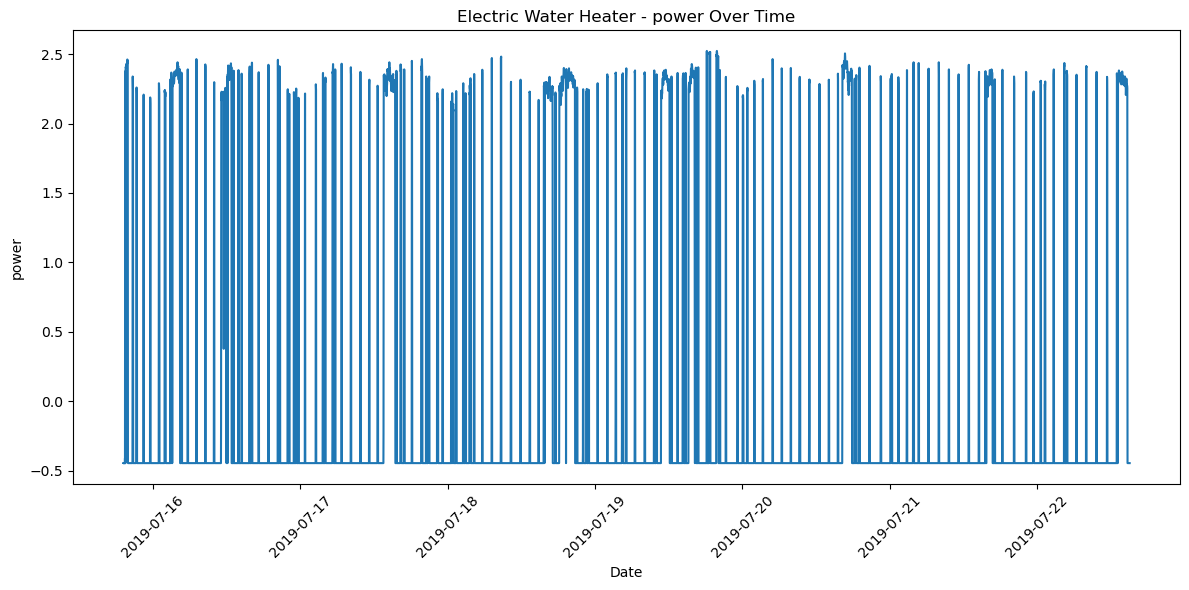

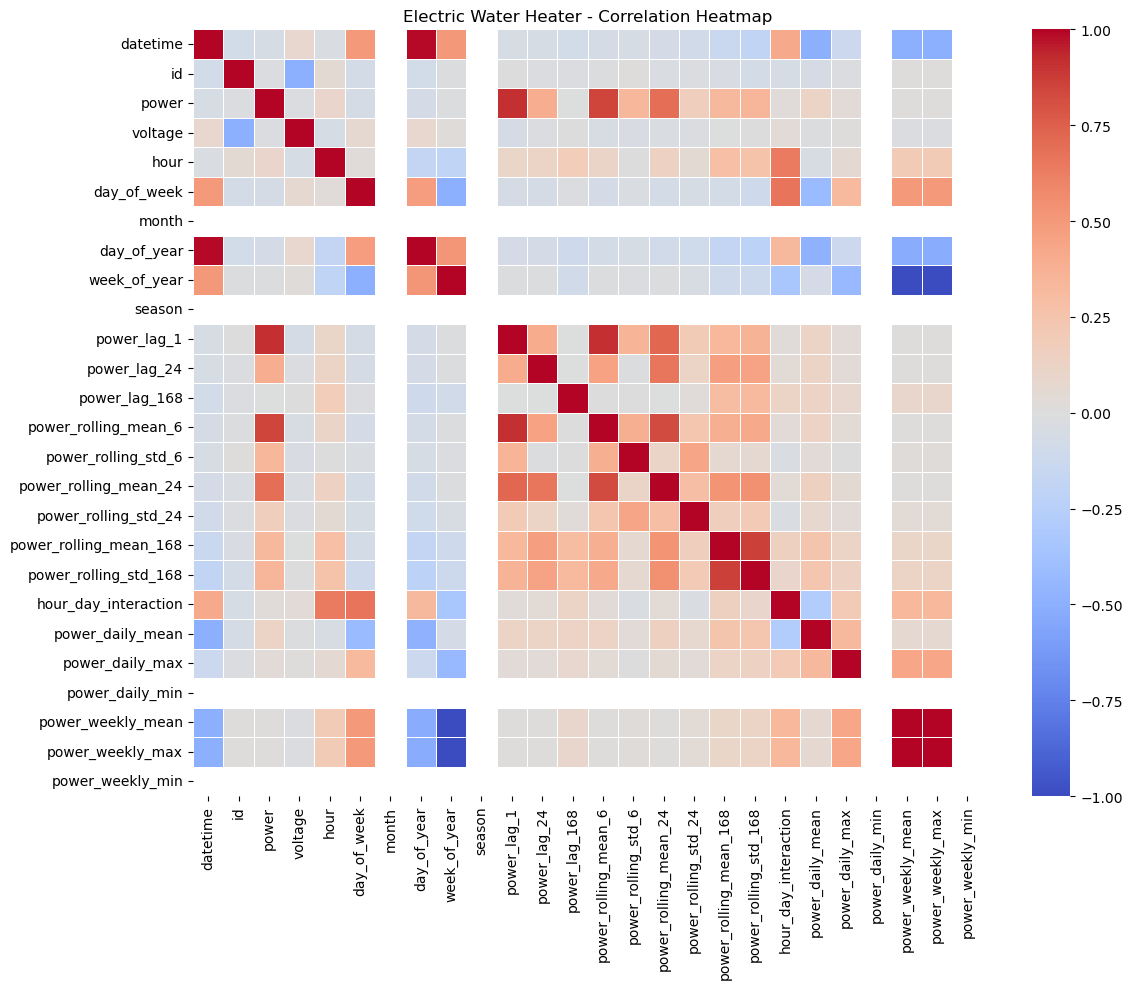


Top 5 correlations with power:
power                    1.000000
power_lag_1              0.913965
power_rolling_mean_6     0.849228
power_rolling_mean_24    0.694801
power_lag_24             0.396202
power_rolling_std_168    0.350916
Name: power, dtype: float64


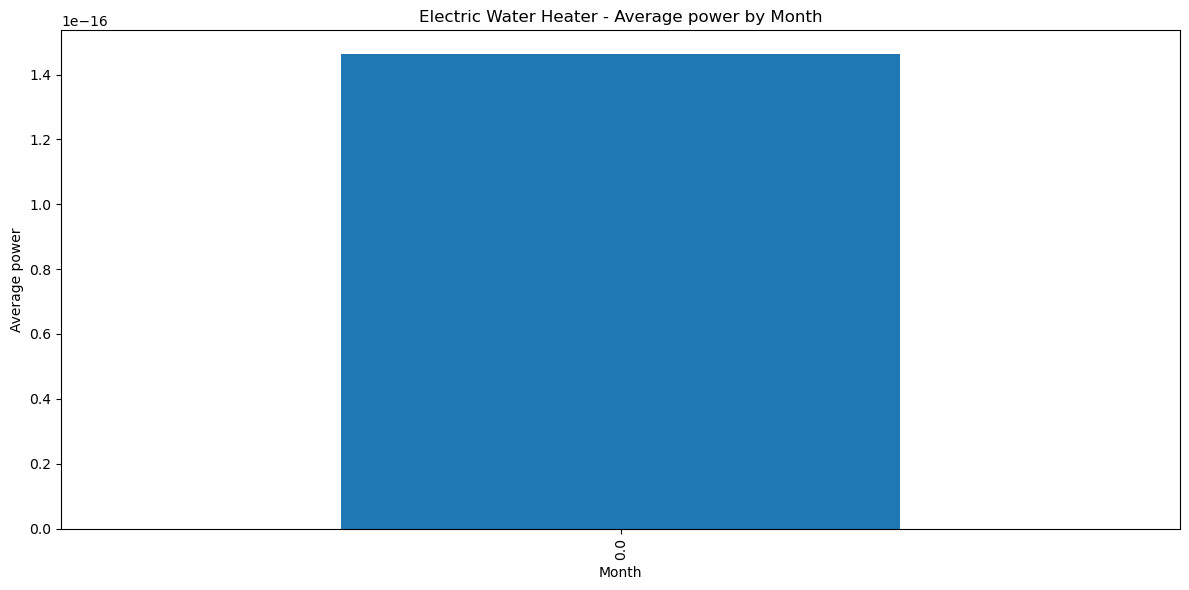

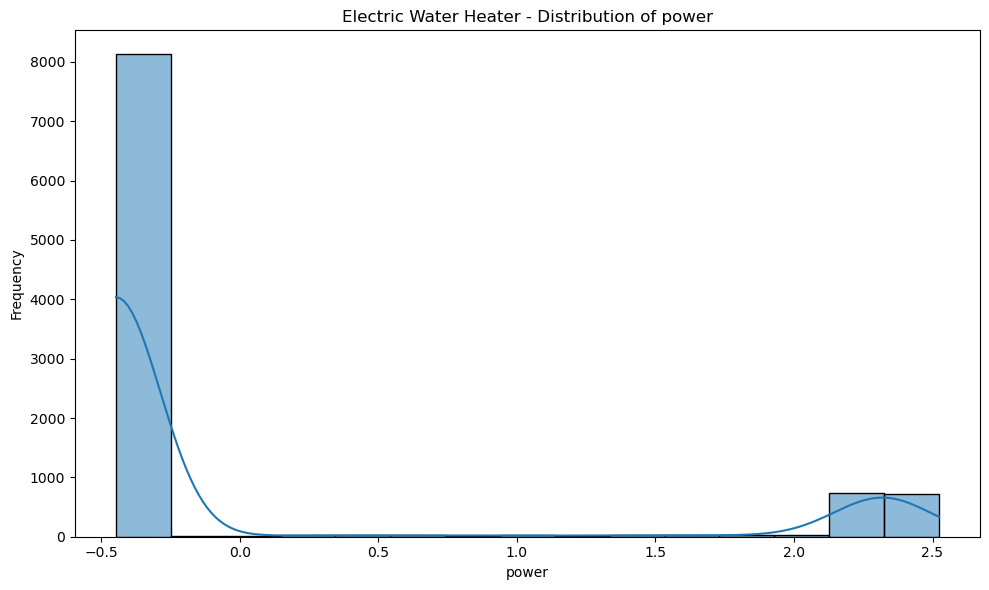

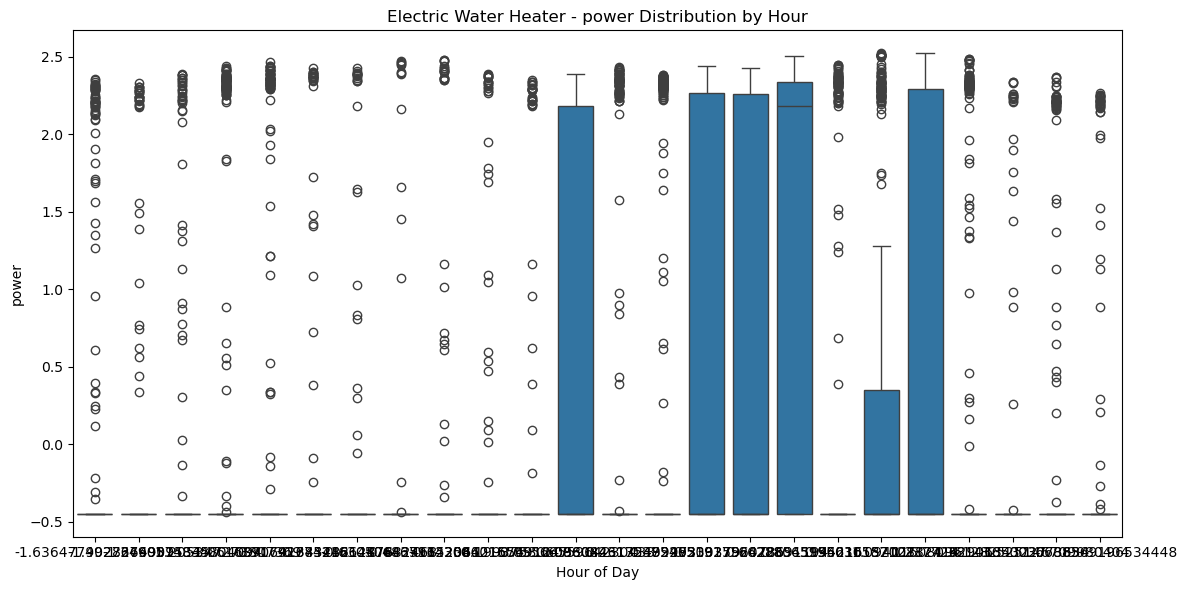

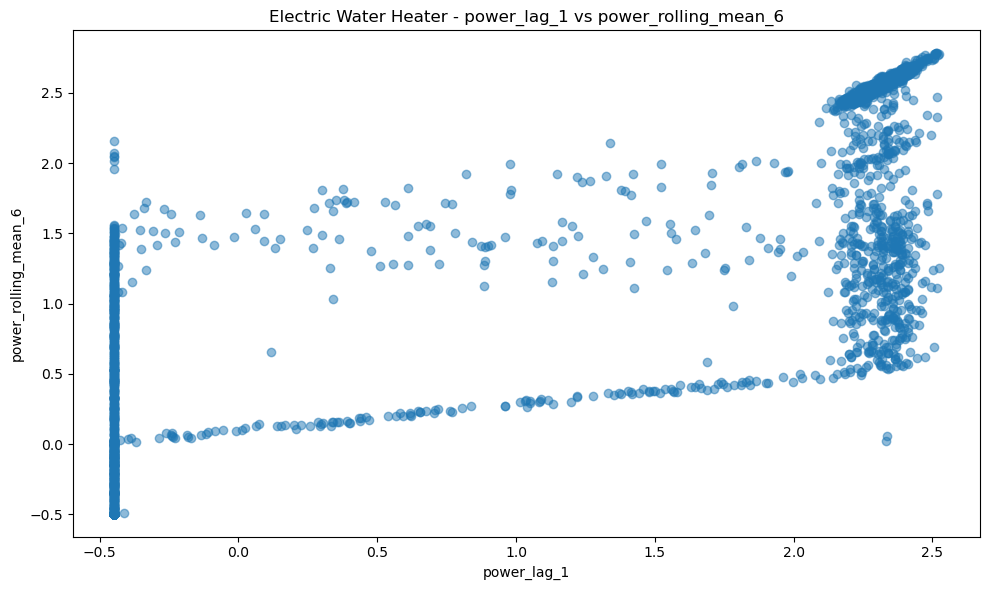


Number of outliers in power (based on Z-score > 3): 0


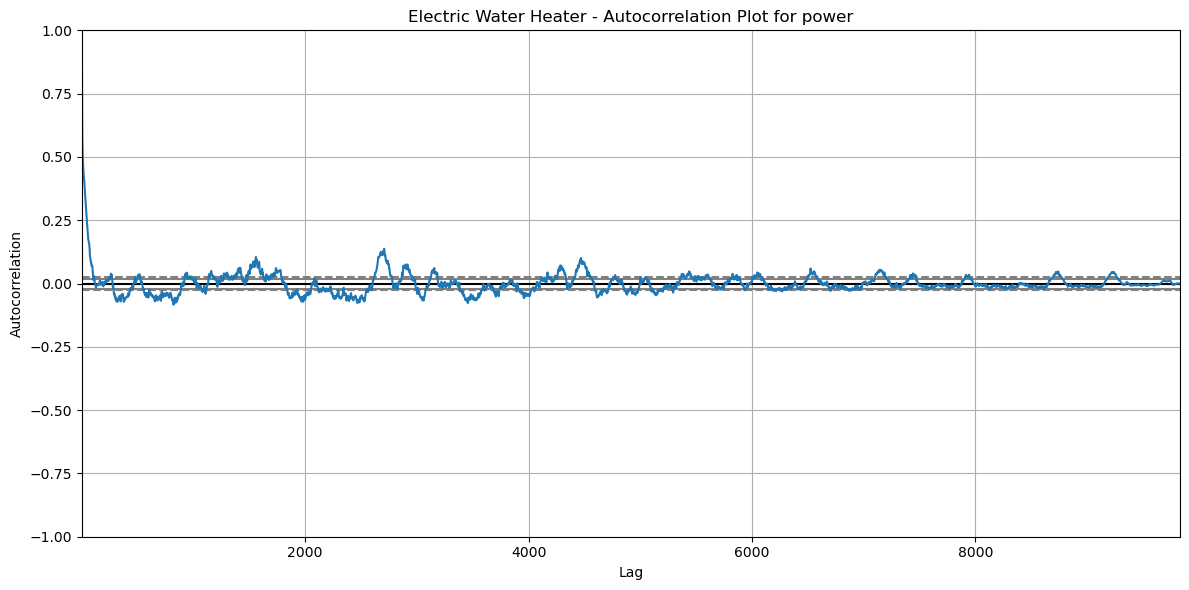

In [13]:
# Perform EDA on Electric Water Heater dataset
perform_eda(EWH, "Electric Water Heater", "power")



Performing EDA on Disaggregated Energy Consumption dataset

Basic statistics:
                            datetime       aenergy   aenergy_ph1  \
count                         144088  1.440880e+05  1.440880e+05   
mean   2019-09-07 02:15:23.257182720  1.025713e-17  3.747796e-17   
min              2019-08-27 22:28:05 -6.317515e-01 -5.445712e-01   
25%              2019-09-01 09:24:05 -5.469057e-01 -5.384943e-01   
50%              2019-09-07 20:12:05 -3.772141e-01 -5.118061e-01   
75%              2019-09-12 09:00:23  1.318605e-01 -1.144980e-01   
max              2019-09-16 17:05:07  3.271264e+01  2.370954e+00   
std                              NaN  1.000003e+00  1.000003e+00   

        aenergy_ph2   aenergy_ph3       renergy   renergy_ph1   renergy_ph2  \
count  1.440880e+05  1.440880e+05  1.440880e+05  1.440880e+05  1.440880e+05   
mean  -4.388867e-18  7.801334e-17 -1.242690e-17  1.617470e-17  1.540542e-16   
min   -4.444434e-01 -4.452641e-01 -5.332129e-01 -8.389087e-01 -4.940613

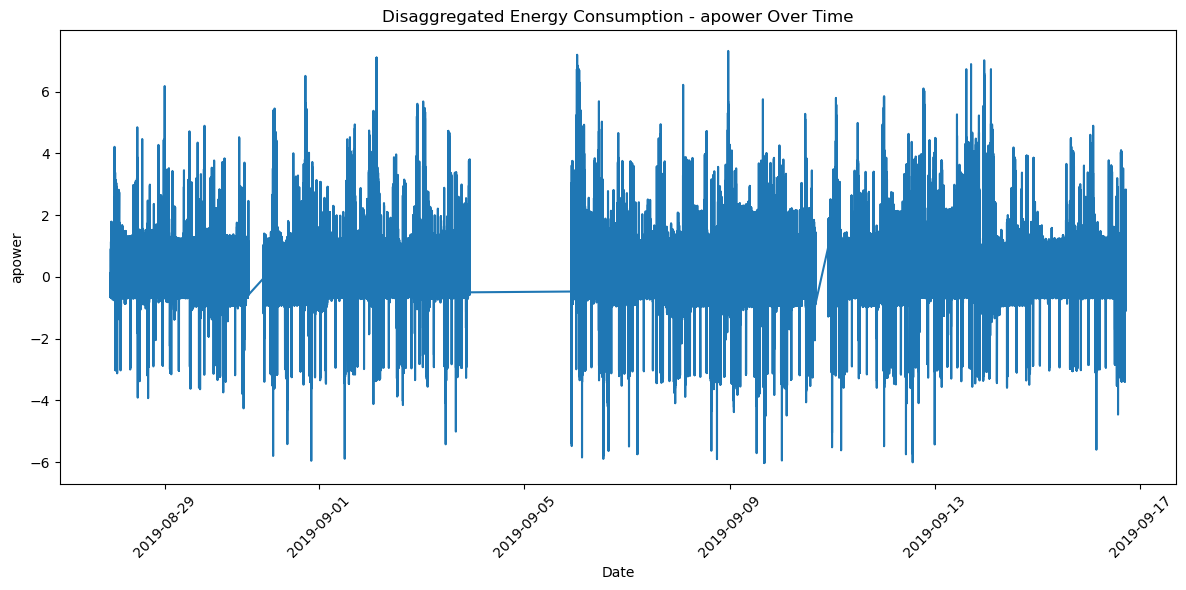

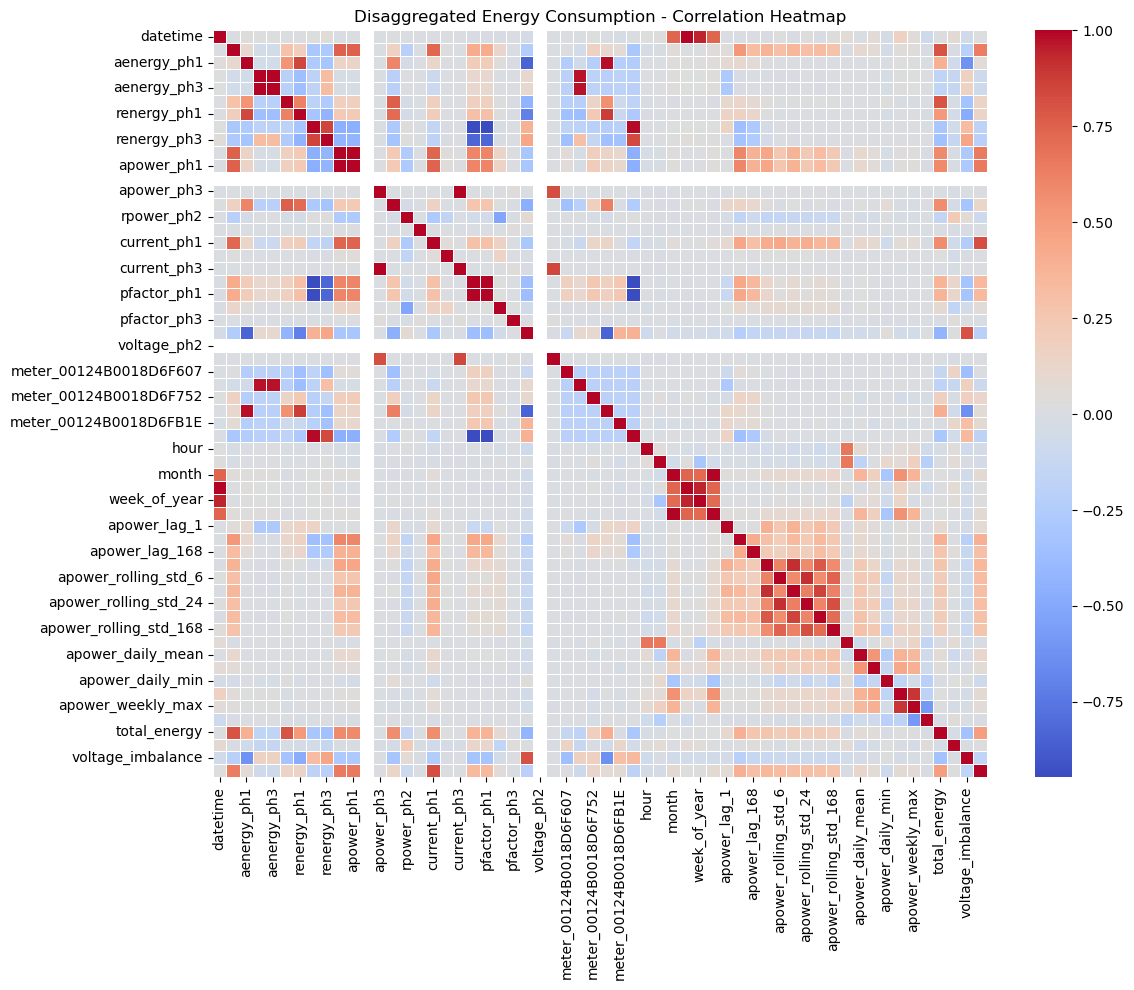


Top 5 correlations with apower:
apower               1.000000
apower_ph1           0.995468
aenergy              0.752757
current_ph1          0.739383
current_imbalance    0.649472
pfactor              0.611526
Name: apower, dtype: float64


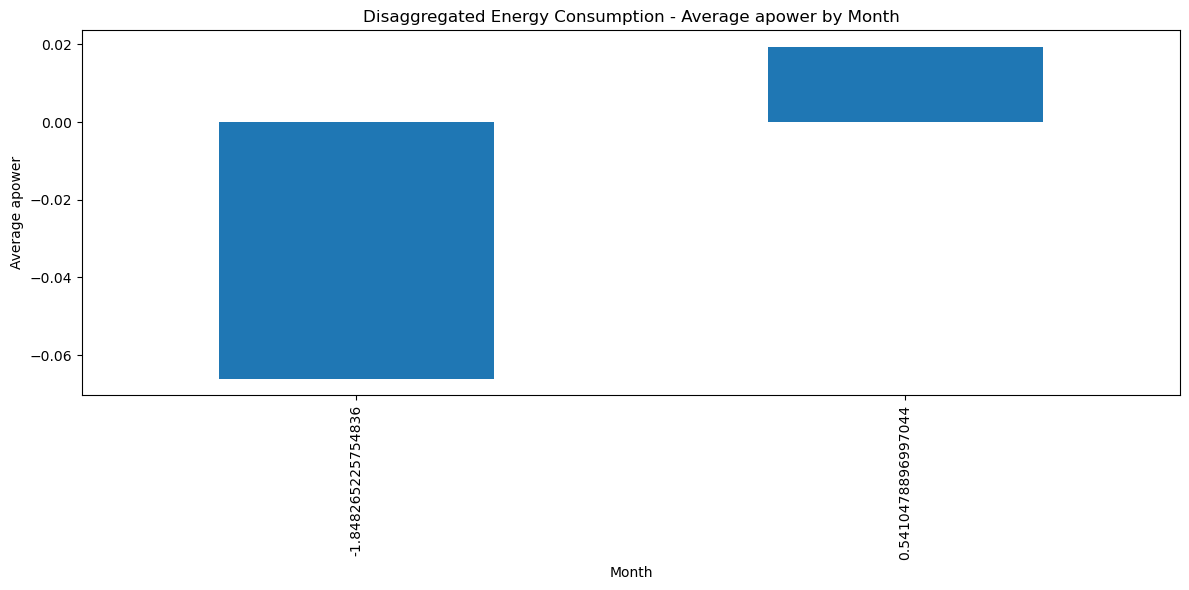

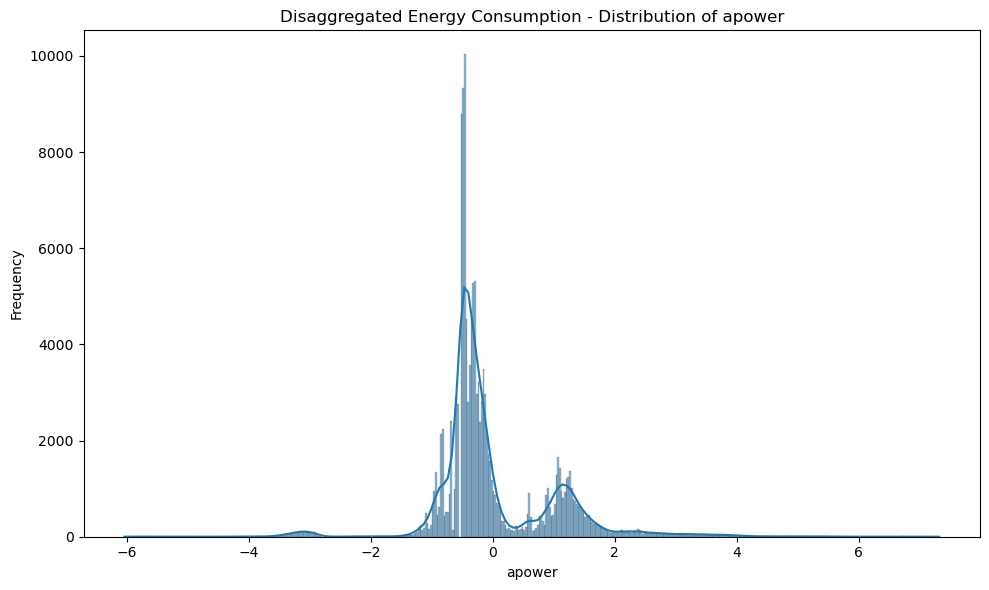

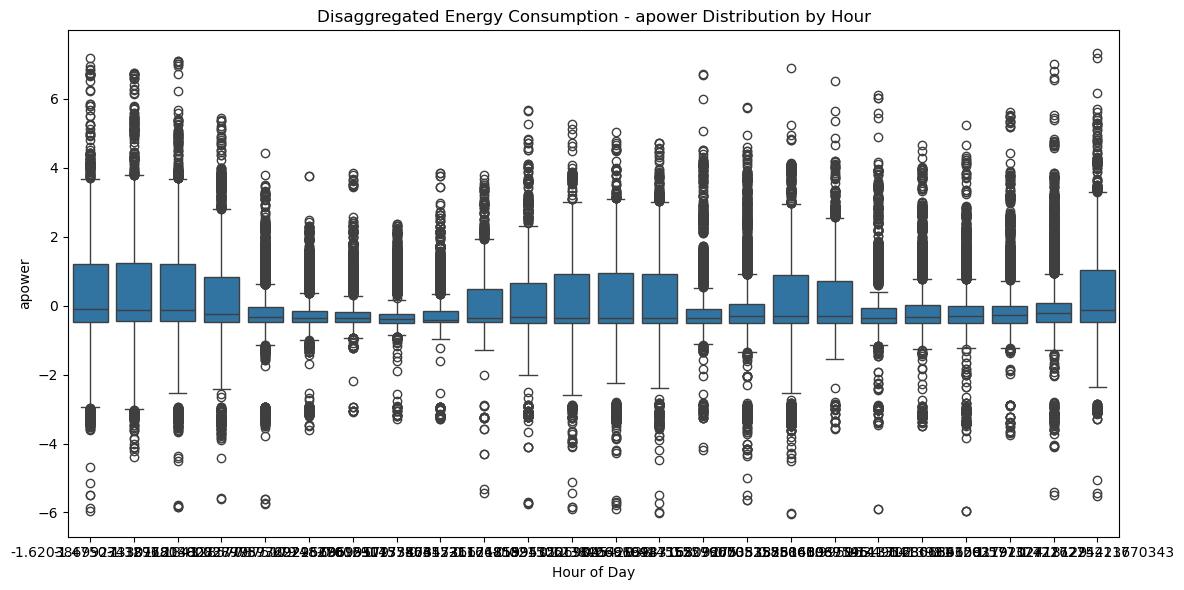

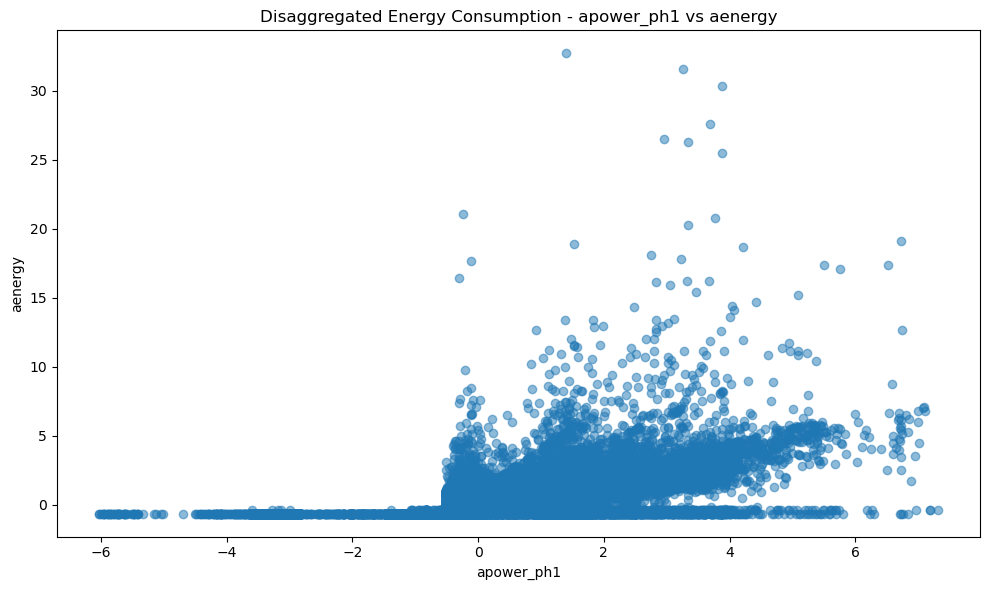


Number of outliers in apower (based on Z-score > 3): 3837


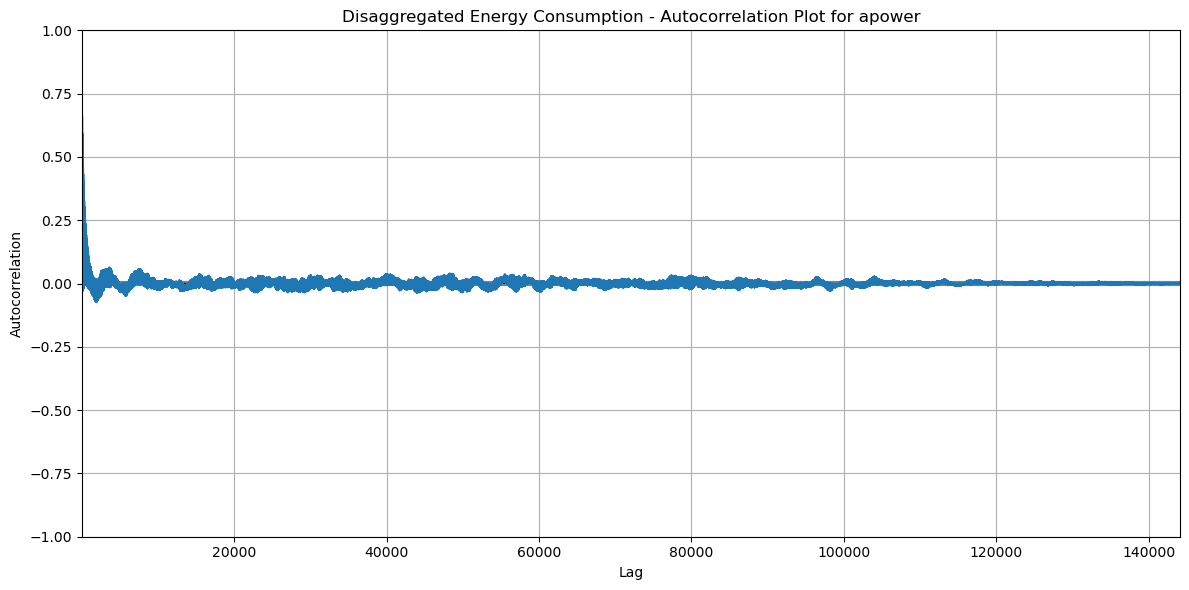


Additional EDA for Disaggregated Energy Consumption dataset


<Figure size 1200x600 with 0 Axes>

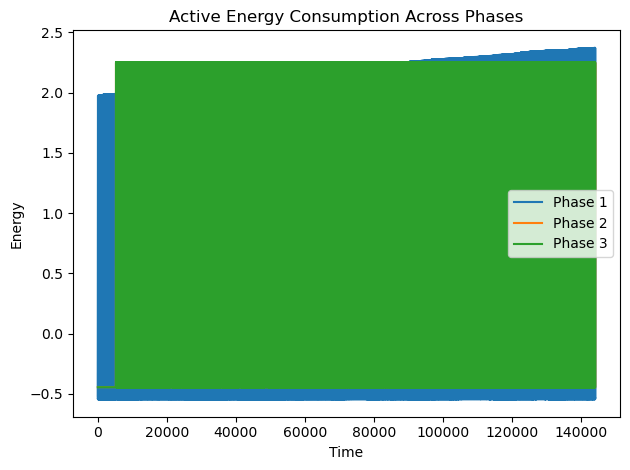

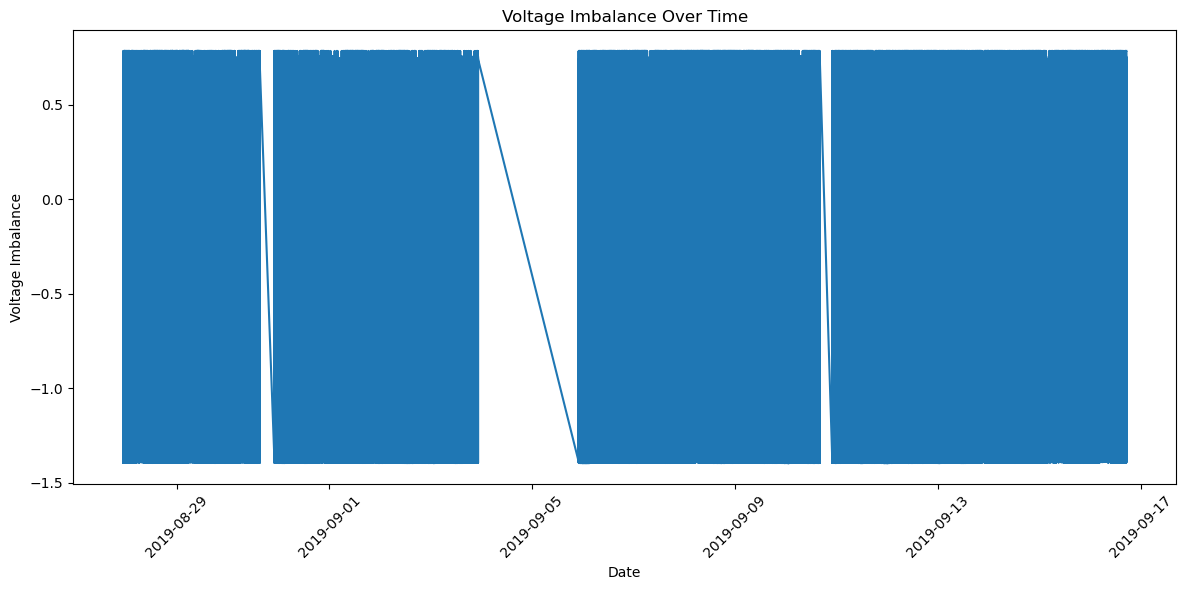

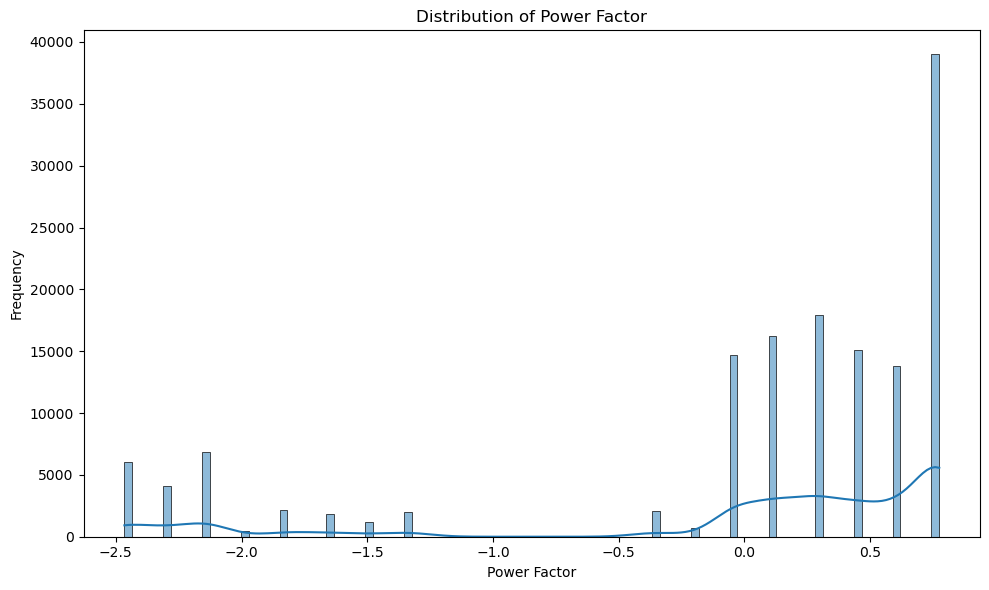

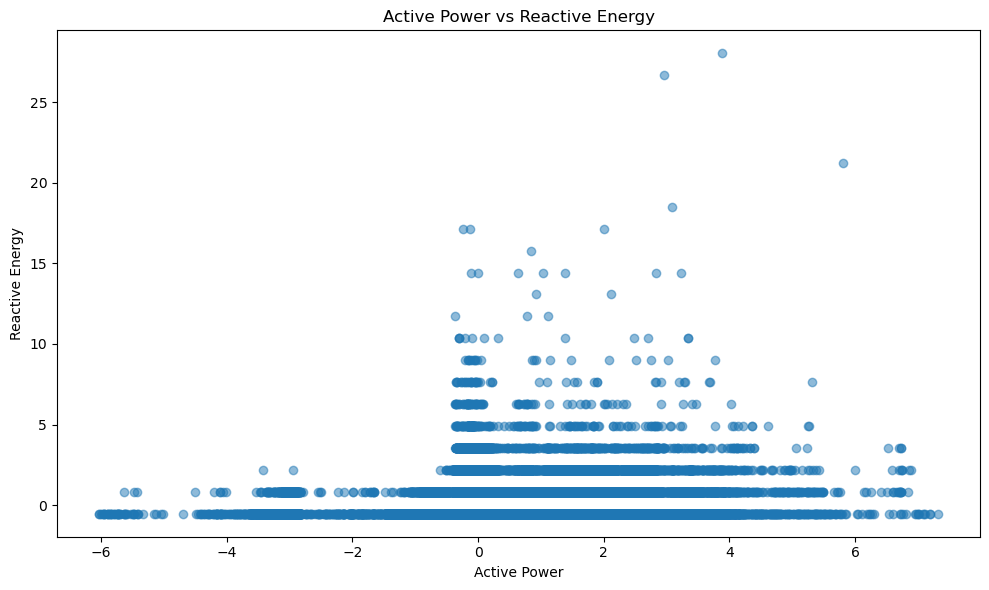

Exploratory Data Analysis complete.


In [14]:
# Perform EDA on Disaggregated Energy Consumption dataset
perform_eda(DEC, "Disaggregated Energy Consumption", "apower")

#  Specific EDA  for DEC dataset
def specific_eda_dec(df):
    print("\nAdditional EDA for Disaggregated Energy Consumption dataset")
    
    # 1. Compare energy consumption across phases
    plt.figure(figsize=(12, 6))
    df[['aenergy_ph1', 'aenergy_ph2', 'aenergy_ph3']].plot()
    plt.title('Active Energy Consumption Across Phases')
    plt.xlabel('Time')
    plt.ylabel('Energy')
    plt.legend(['Phase 1', 'Phase 2', 'Phase 3'])
    plt.tight_layout()
    plt.show()
    
    # 2. Voltage imbalance over time
    plt.figure(figsize=(12, 6))
    plt.plot(df['datetime'], df['voltage_imbalance'])
    plt.title('Voltage Imbalance Over Time')
    plt.xlabel('Date')
    plt.ylabel('Voltage Imbalance')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 3. Power factor distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df['pfactor'], kde=True)
    plt.title('Distribution of Power Factor')
    plt.xlabel('Power Factor')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
    # 4. Relationship between active and reactive power
    plt.figure(figsize=(10, 6))
    plt.scatter(df['apower'], df['renergy'], alpha=0.5)
    plt.title('Active Power vs Reactive Energy')
    plt.xlabel('Active Power')
    plt.ylabel('Reactive Energy')
    plt.tight_layout()
    plt.show()

# Specific EDA on DEC dataset
specific_eda_dec(DEC)

print("Exploratory Data Analysis complete.")

# Model Development


Processing THC dataset


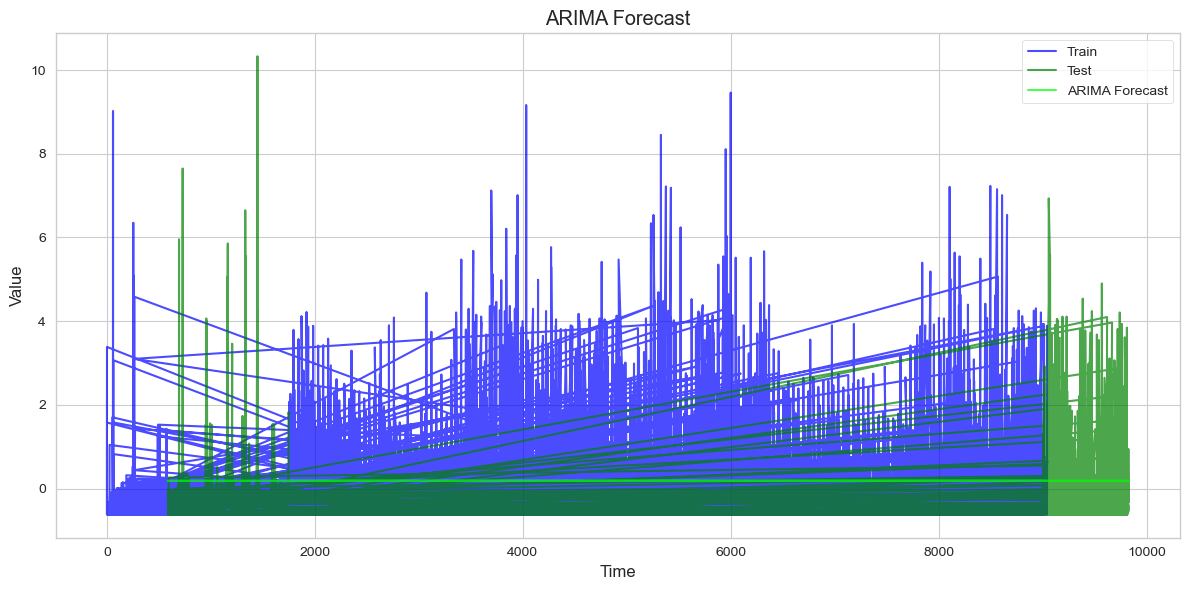

ARIMA Performance:
MSE: 0.8915
RMSE: 0.9442
MAE: 0.6738
R2 Score: -0.0988



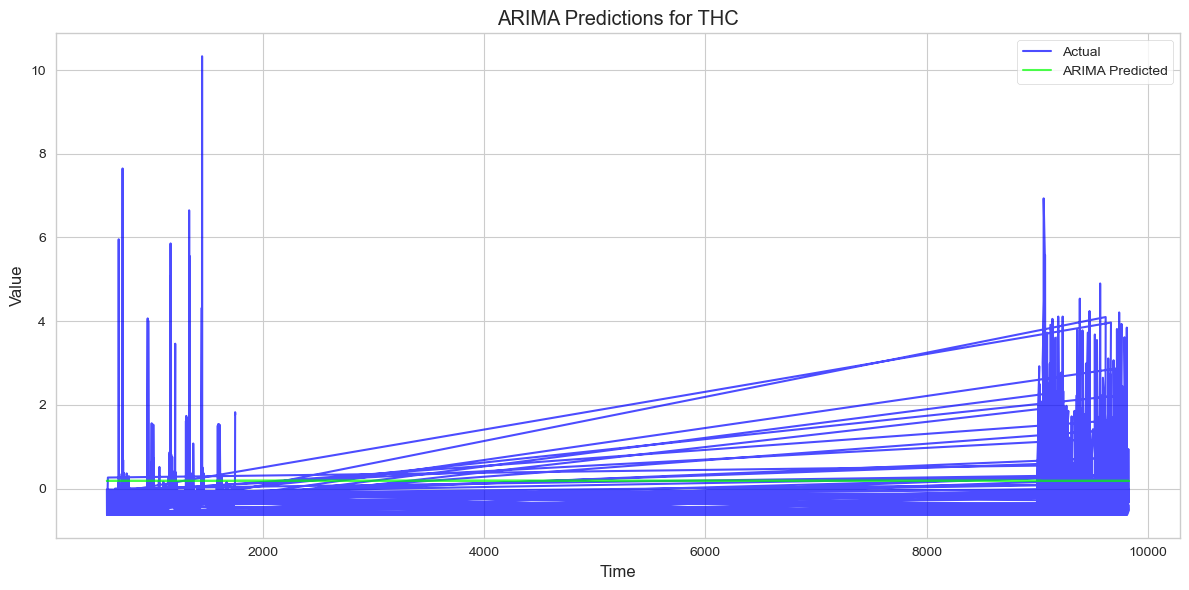

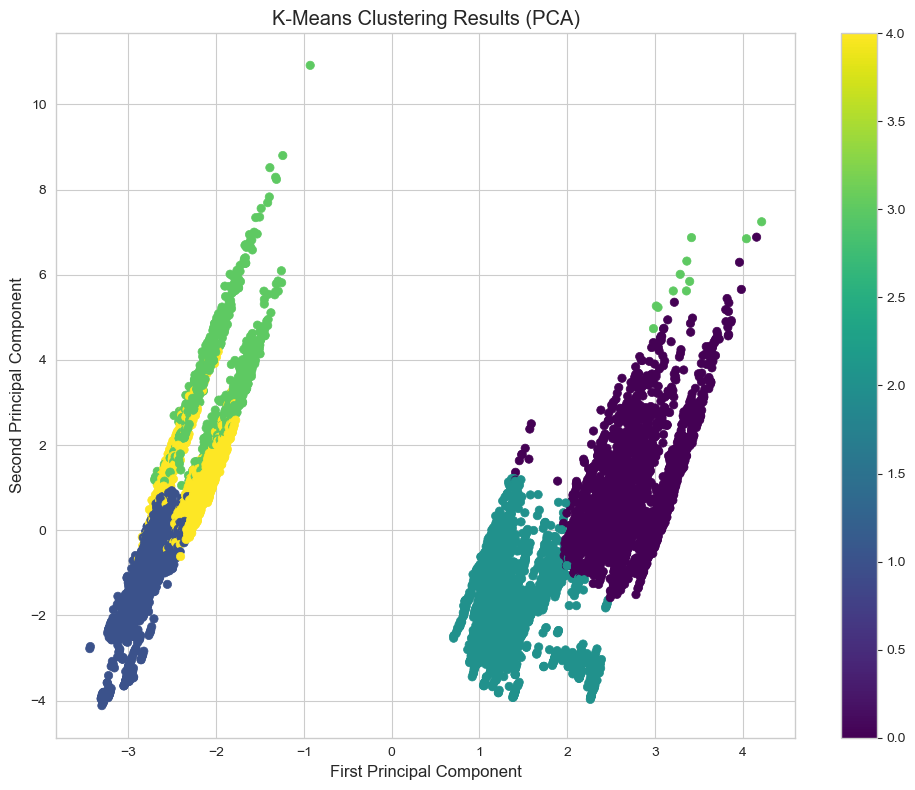

K-Means clustering applied. Cluster distribution: [2242 1740 2031  626 1225]


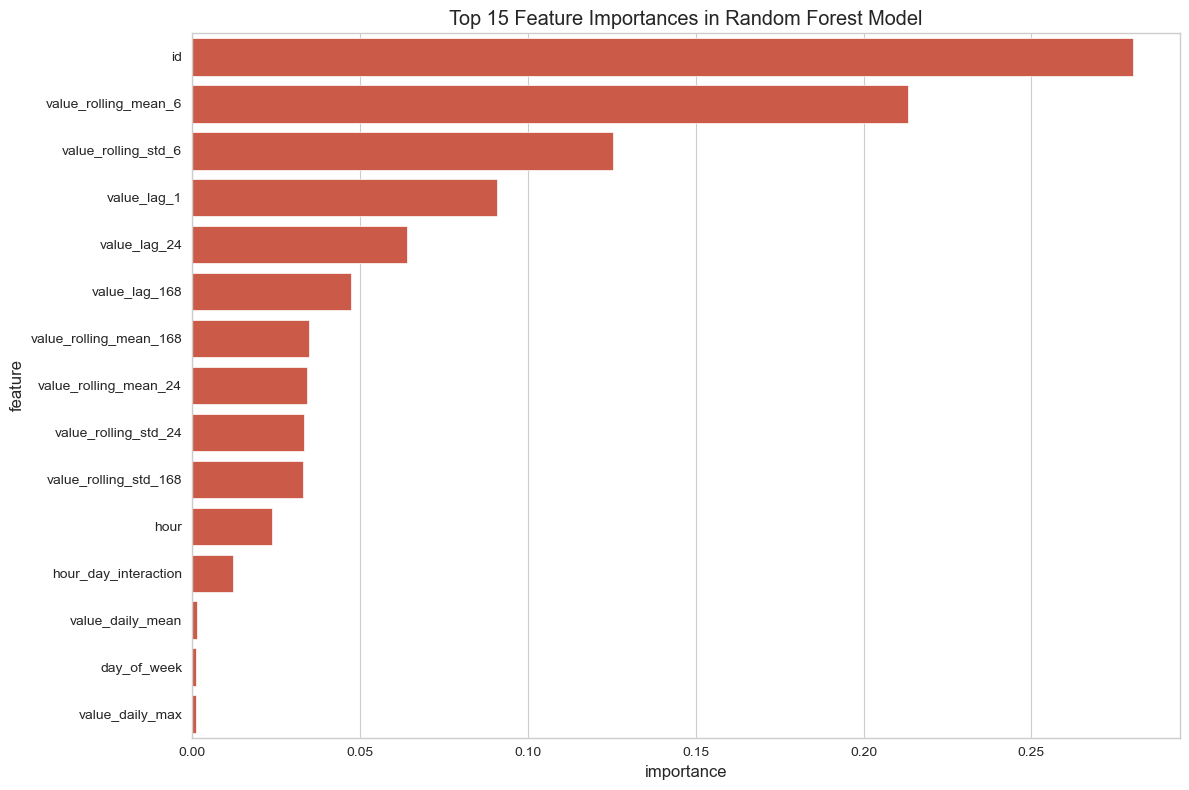

Random Forest Performance:
MSE: 0.4716
RMSE: 0.6867
MAE: 0.3333
R2 Score: 0.4187



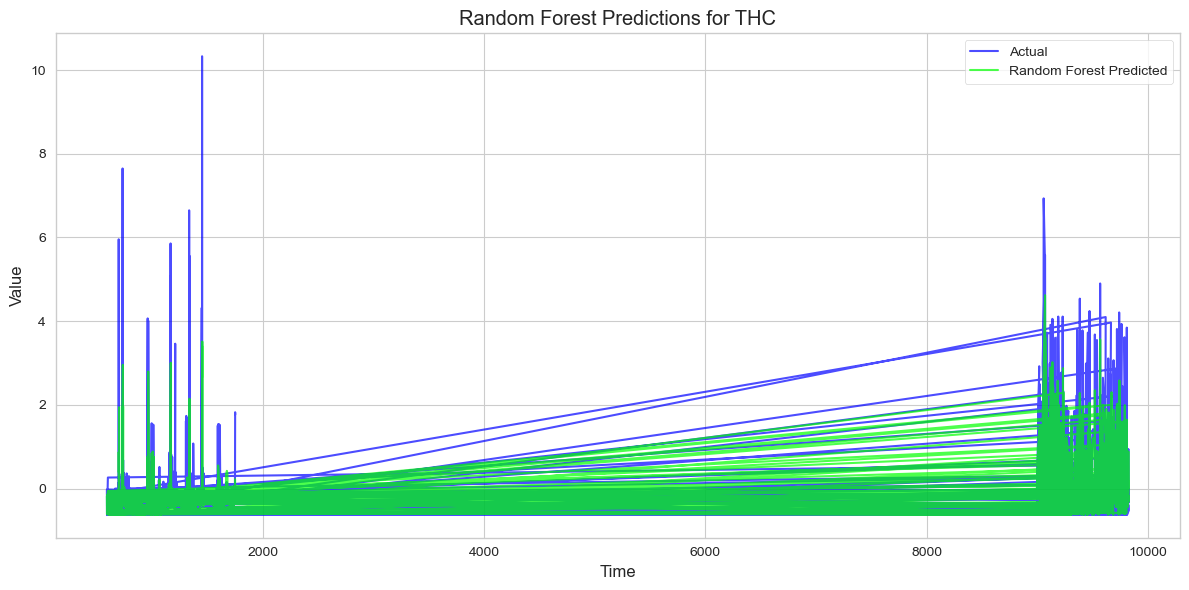

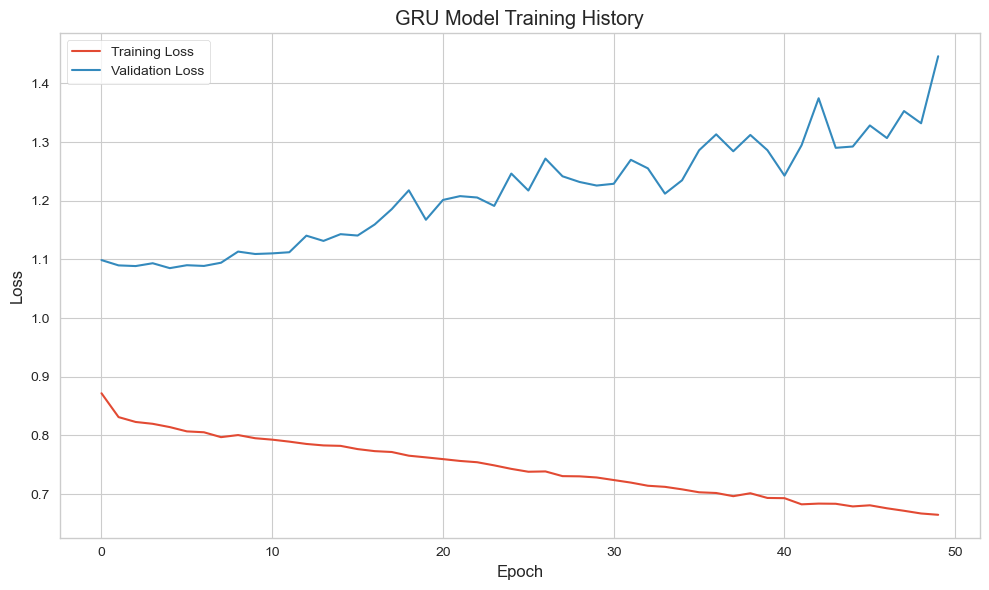

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
GRU Performance:
MSE: 6.2792
RMSE: 2.5058
MAE: 1.5543
R2 Score: -6.7394



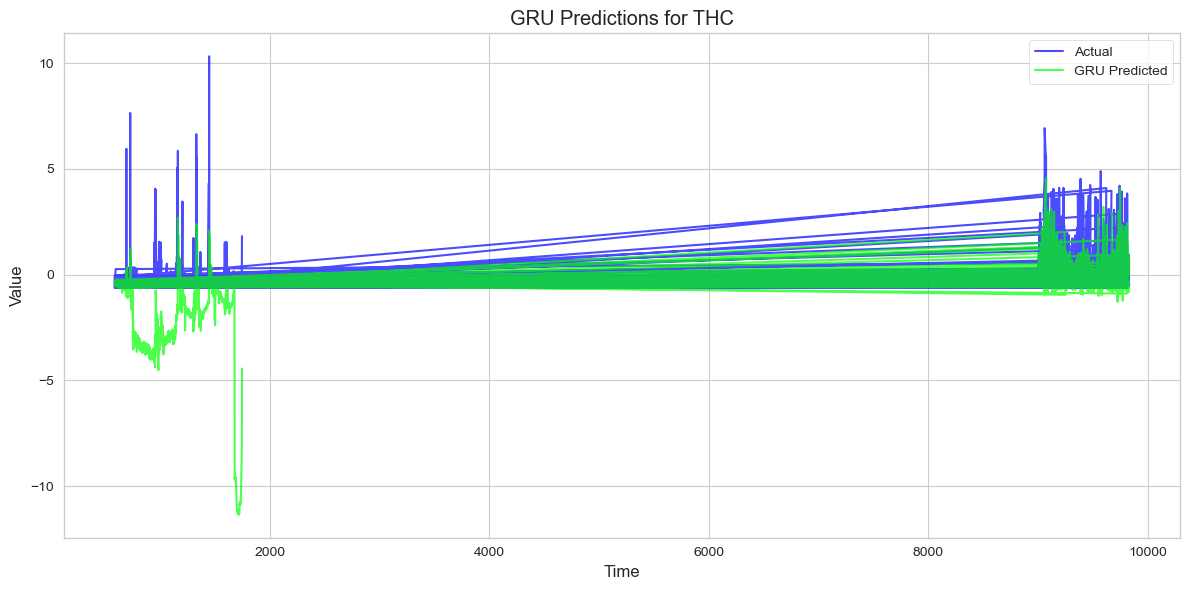

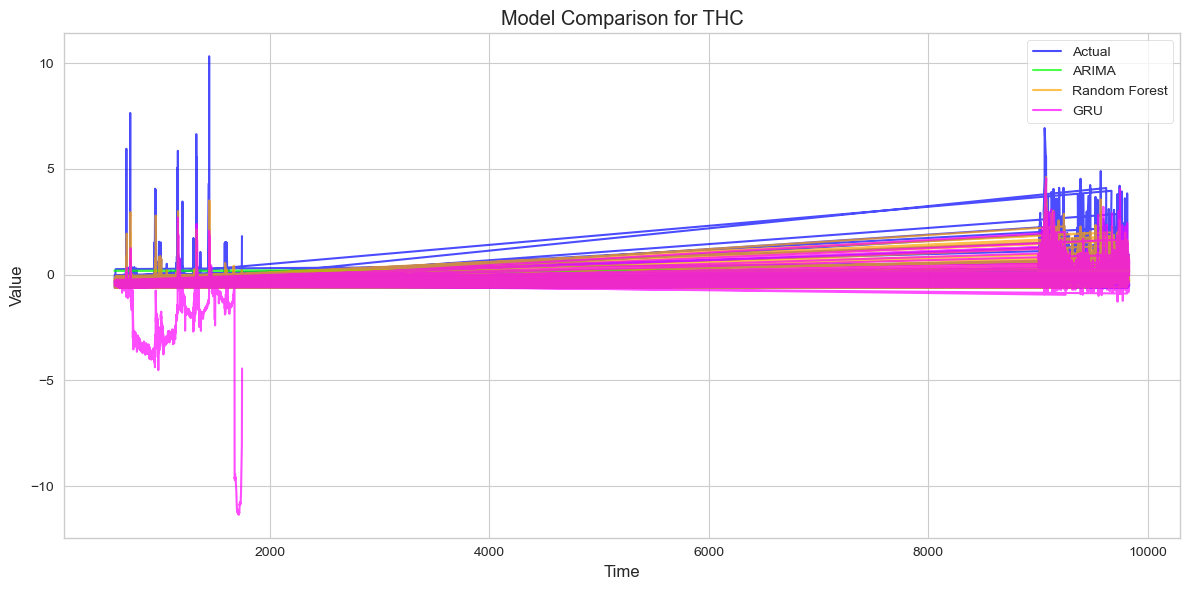


Processing EWH dataset


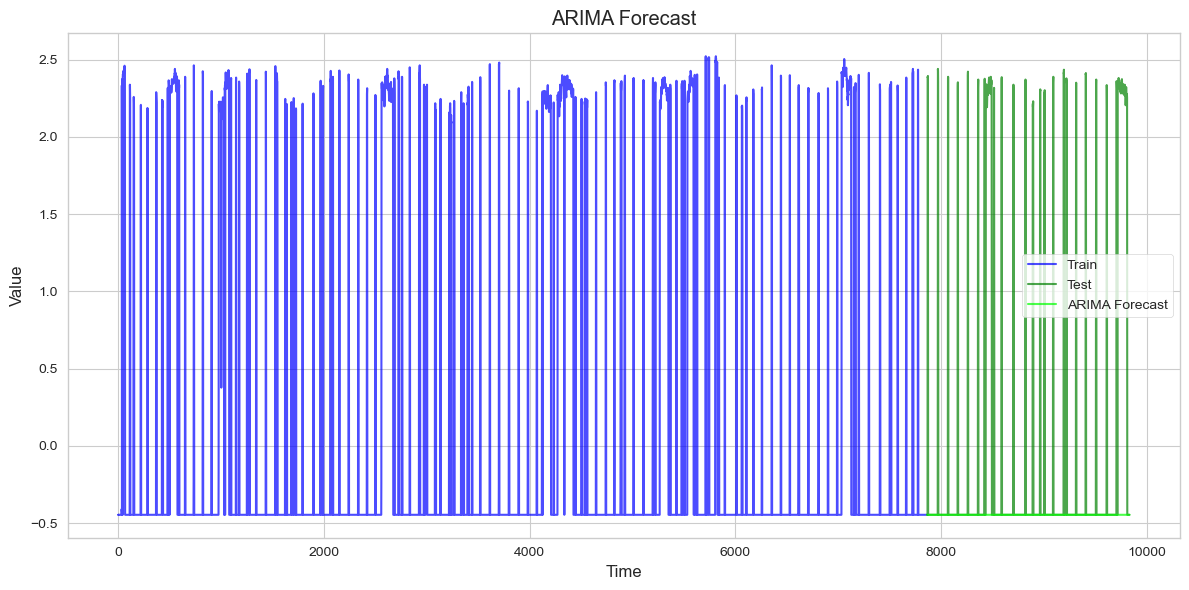

ARIMA Performance:
MSE: 0.9175
RMSE: 0.9578
MAE: 0.3418
R2 Score: -0.1460



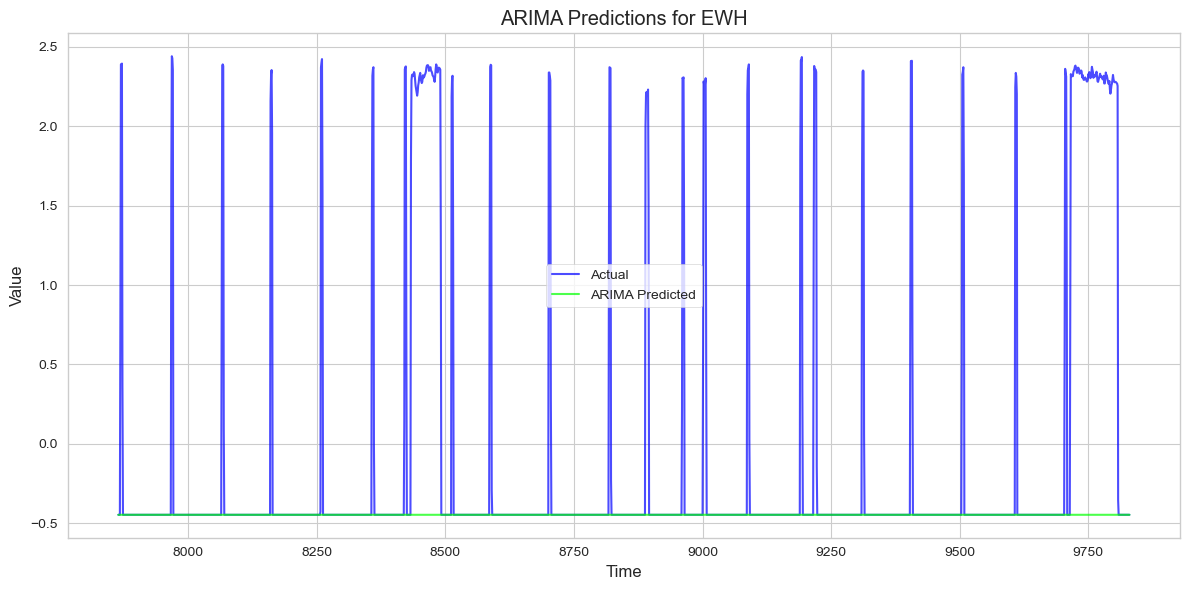

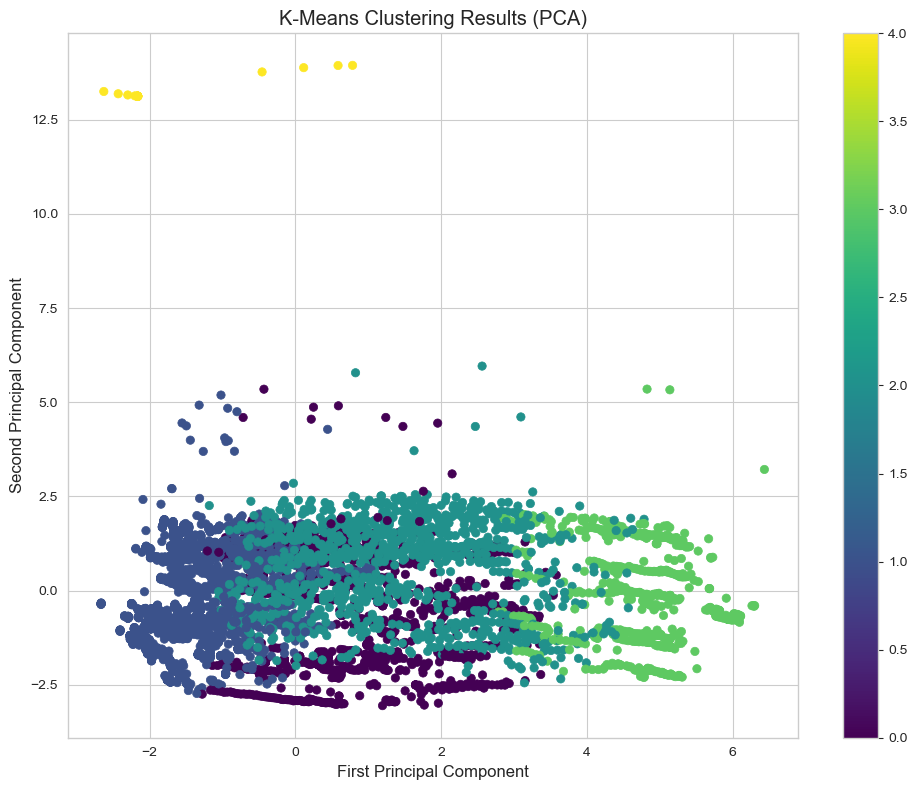

K-Means clustering applied. Cluster distribution: [1734 4284 1080  745   21]


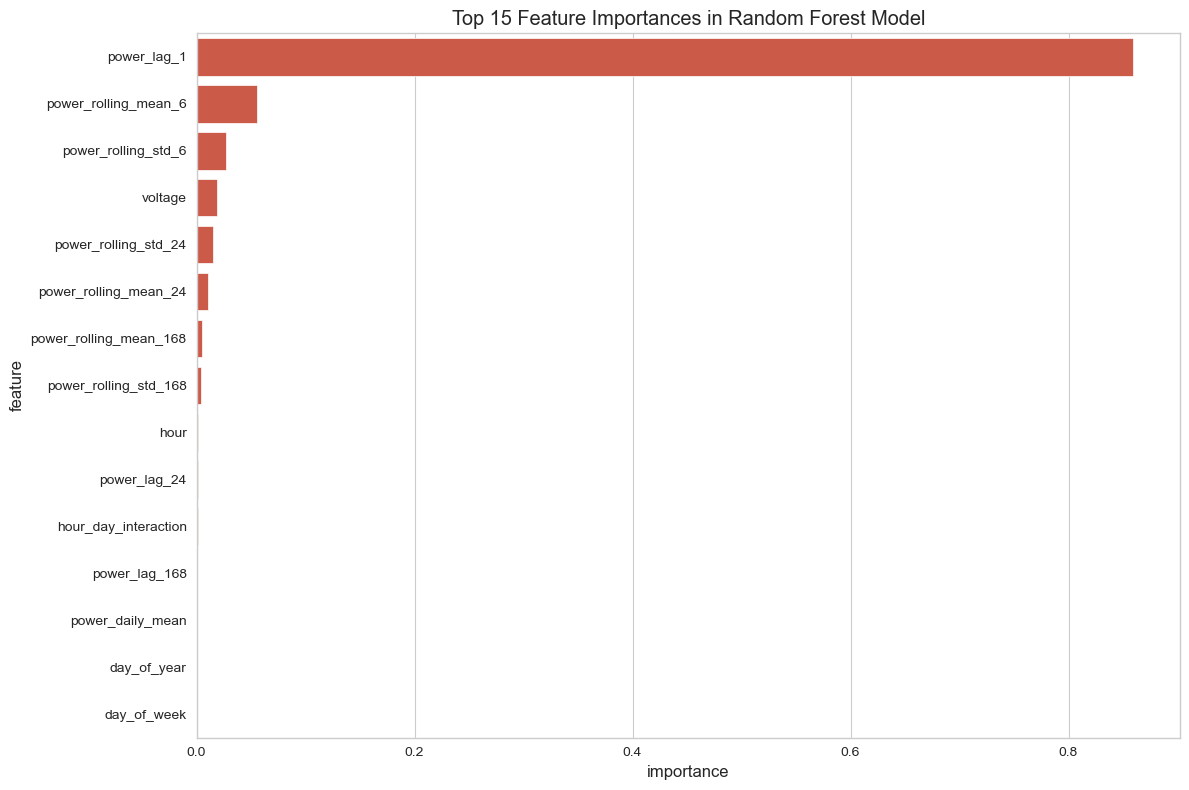

Random Forest Performance:
MSE: 0.0184
RMSE: 0.1355
MAE: 0.0226
R2 Score: 0.9771



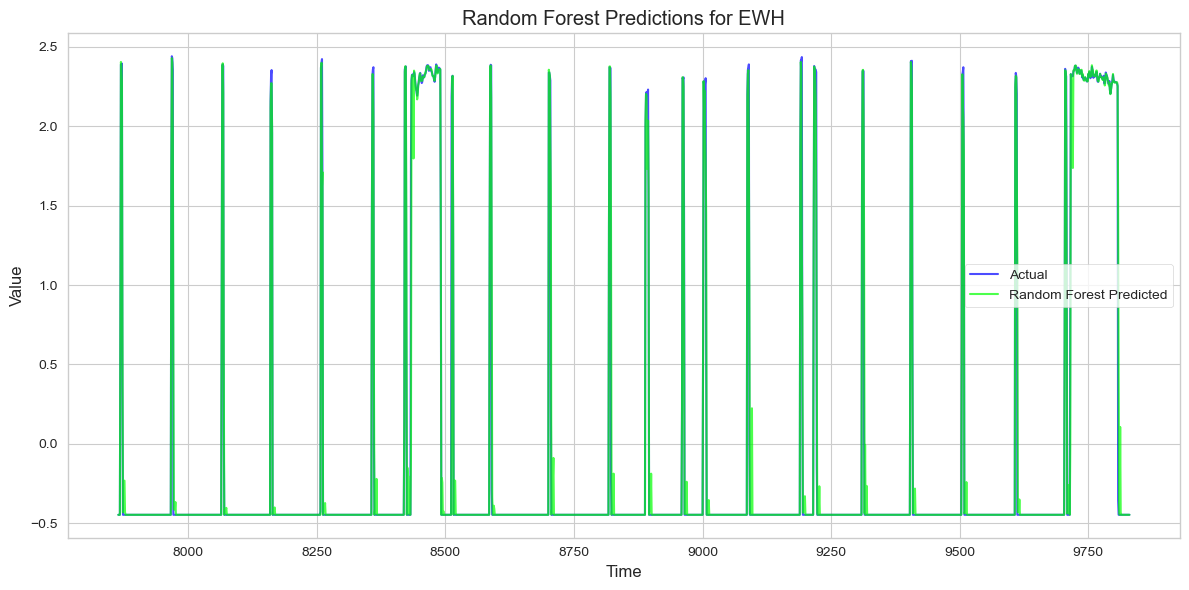

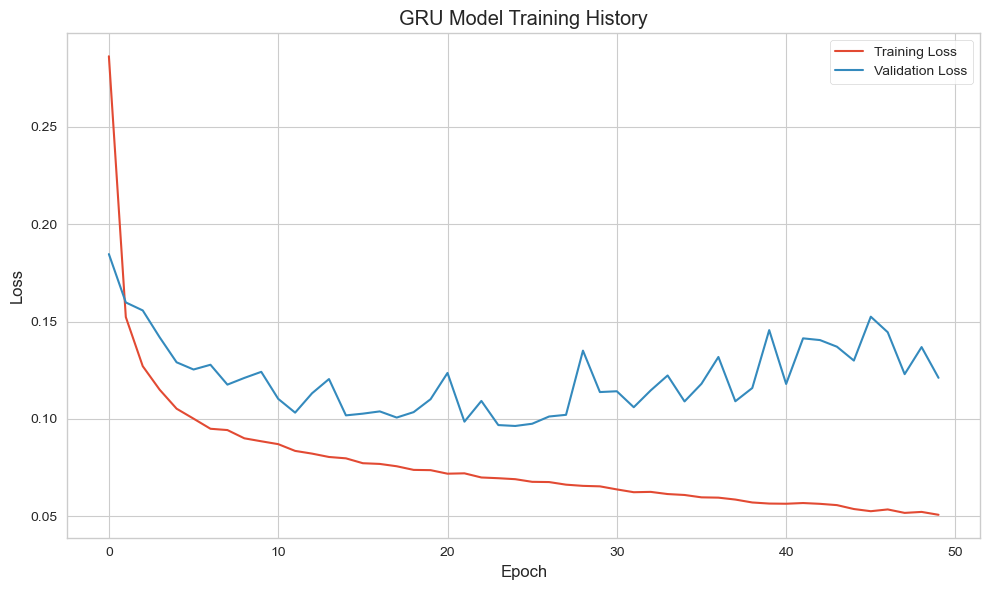

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
GRU Performance:
MSE: 0.1373
RMSE: 0.3705
MAE: 0.2769
R2 Score: 0.8285



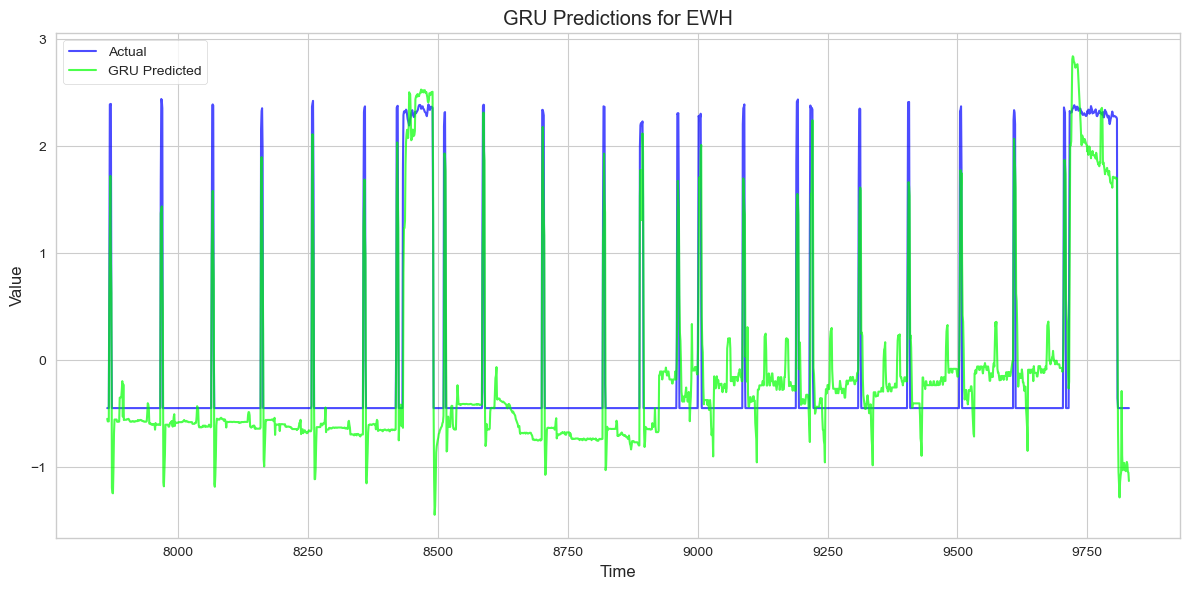

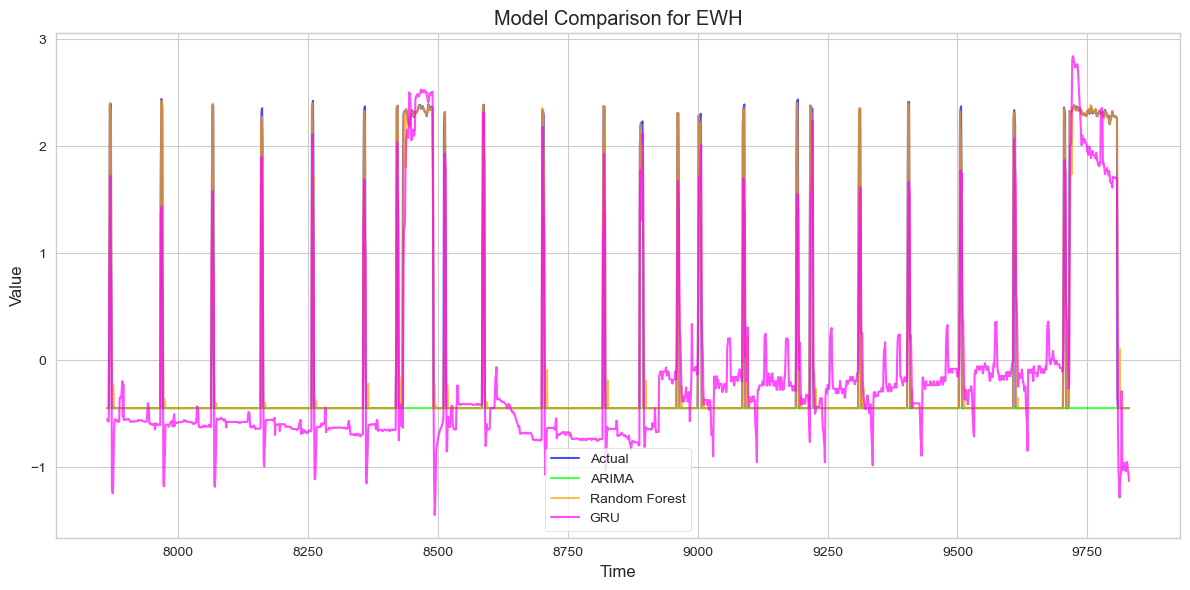


Processing DEC dataset


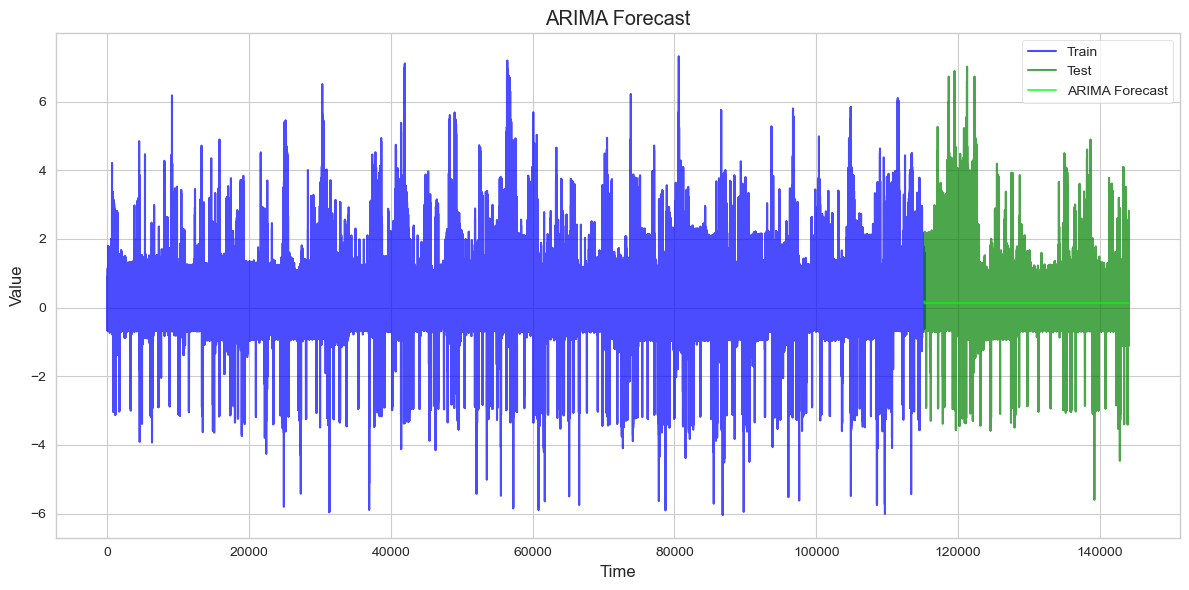

ARIMA Performance:
MSE: 0.9201
RMSE: 0.9592
MAE: 0.7432
R2 Score: -0.0360



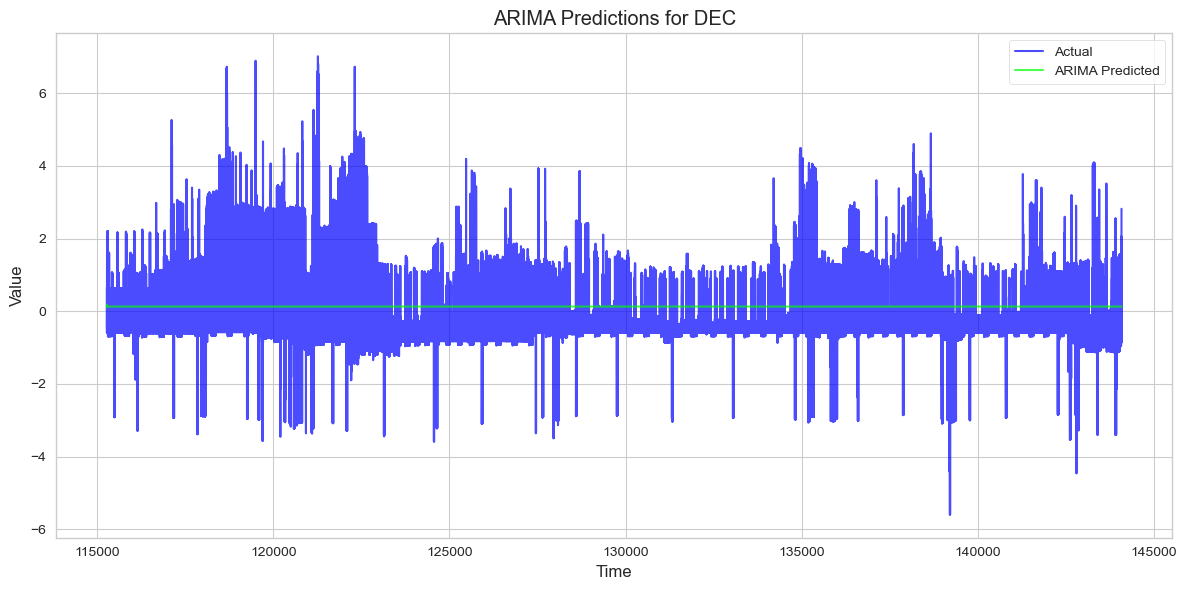

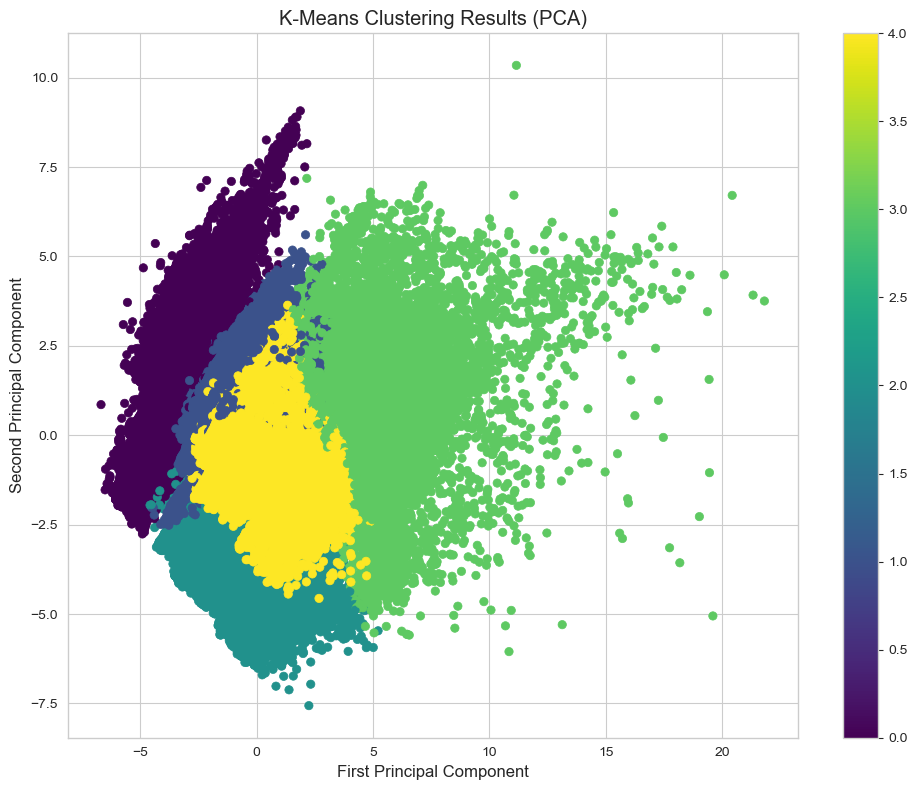

K-Means clustering applied. Cluster distribution: [19694 14232 24321 18493 38530]


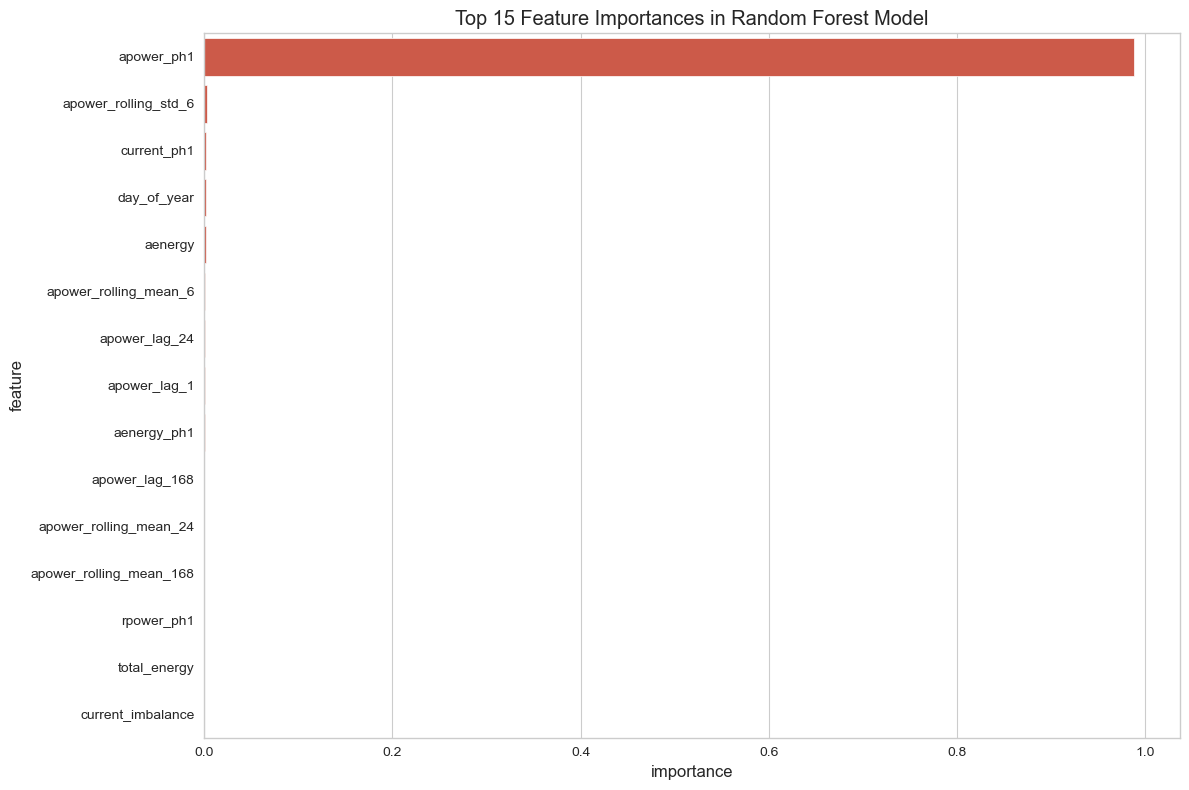

Random Forest Performance:
MSE: 0.0020
RMSE: 0.0443
MAE: 0.0062
R2 Score: 0.9978



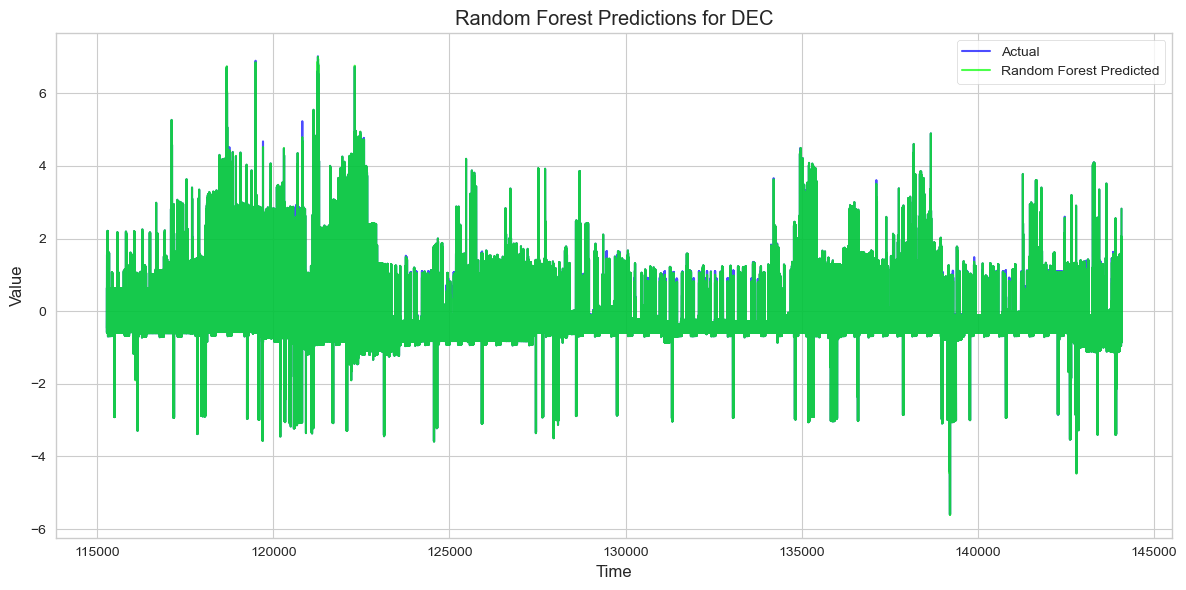

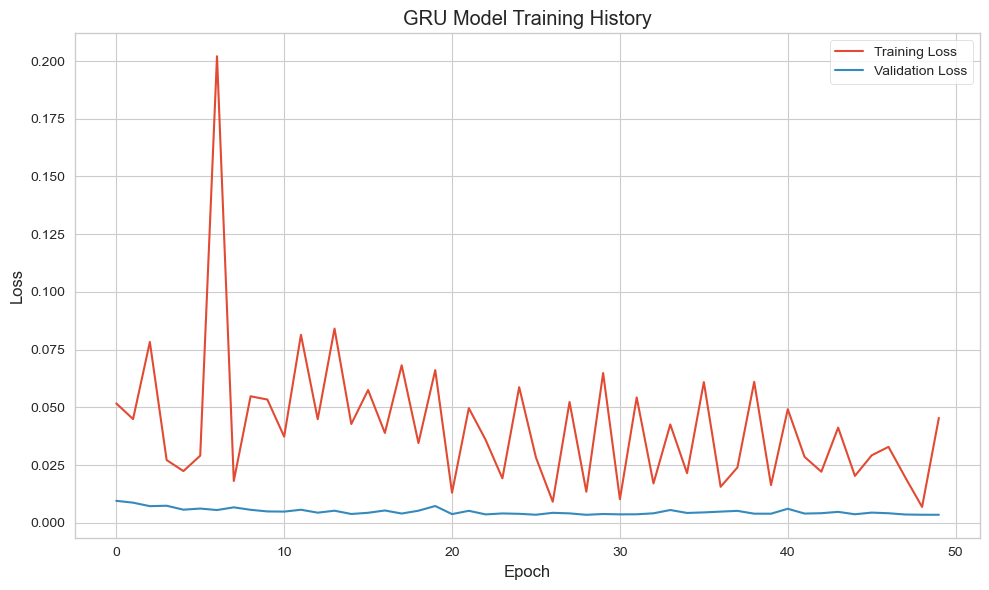

901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
GRU Performance:
MSE: 0.0395
RMSE: 0.1988
MAE: 0.1078
R2 Score: 0.9555



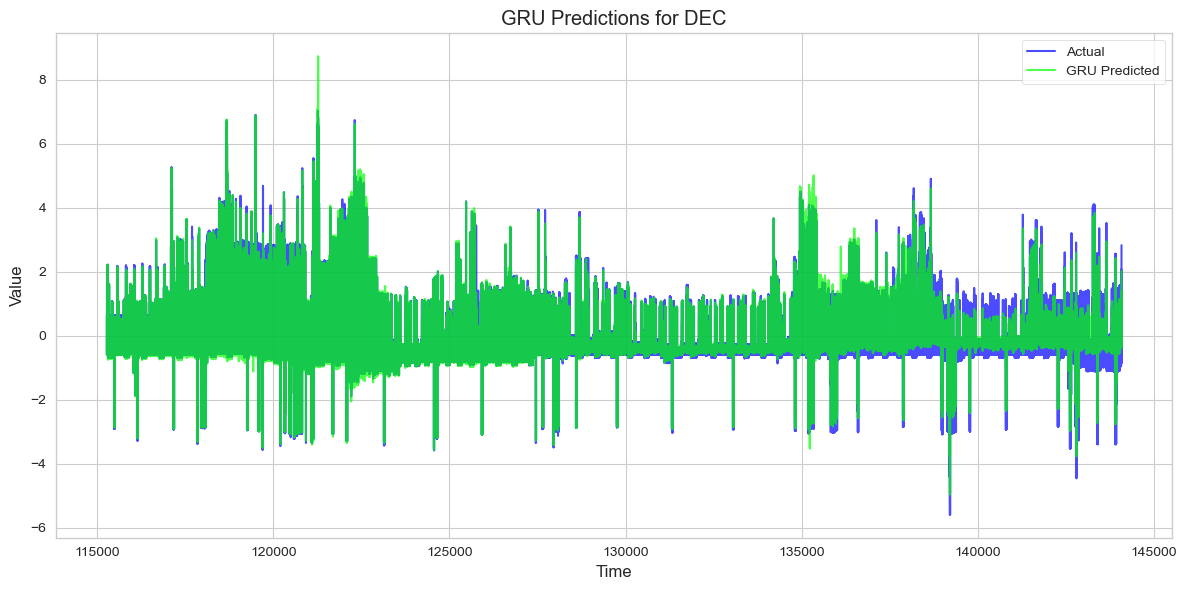

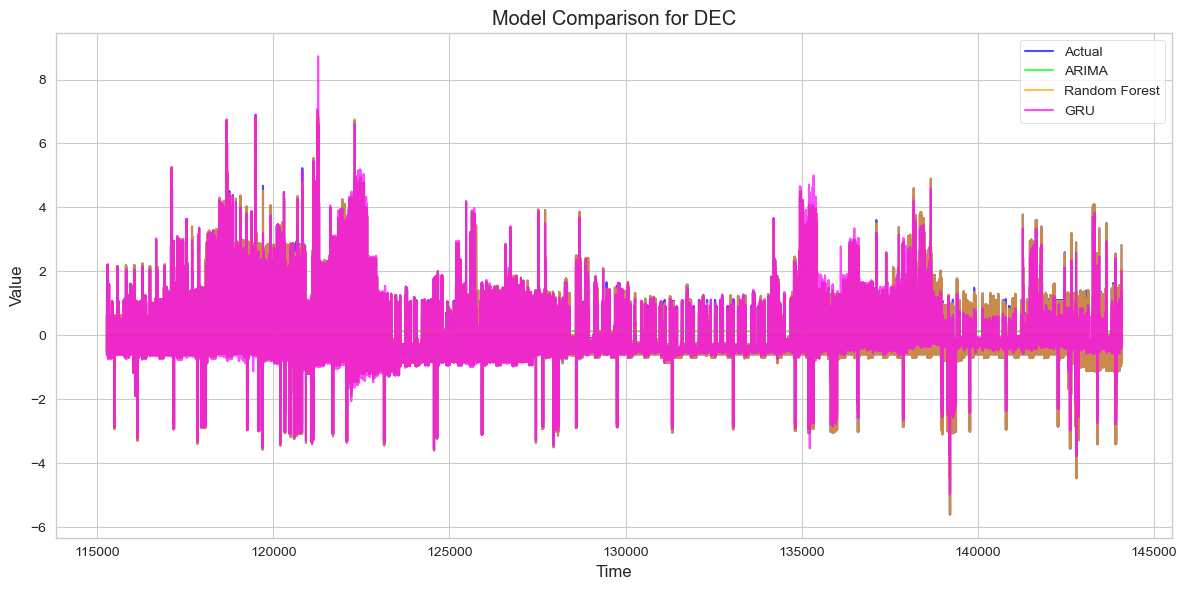


Modeling and evaluation process completed.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import warnings

warnings.filterwarnings("ignore")

plt.style.use('ggplot')
sns.set_style("whitegrid")

# Load the feature-engineered datasets
THC = pd.read_csv("THC_featured.csv")
EWH = pd.read_csv("EWH_featured.csv")
DEC = pd.read_csv("DEC_featured.csv")

for df in [THC, EWH, DEC]:
    df['datetime'] = pd.to_datetime(df['datetime'])

def prepare_data(df, target_column, test_size=0.2):
    df = df.sort_values('datetime')
    bool_columns = df.select_dtypes(include=['bool']).columns
    for col in bool_columns:
        df[col] = df[col].astype(int)
    
    X = df.drop([target_column, 'datetime'], axis=1)
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    return X_train, X_test, y_train, y_test

def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} Performance:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print()

    return mse, rmse, mae, r2

def plot_predictions(y_true, y_pred, title, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true.index, y_true, label='Actual', color='blue', alpha=0.7)
    plt.plot(y_true.index, y_pred, label=f'{model_name} Predicted', color='lime', alpha=0.7)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

def fit_arima(y_train, y_test):
    model = ARIMA(y_train, order=(1,1,1))
    results = model.fit()
    predictions = results.forecast(steps=len(y_test))
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_train.index, y_train, label='Train', color='blue', alpha=0.7)
    plt.plot(y_test.index, y_test, label='Test', color='green', alpha=0.7)
    plt.plot(y_test.index, predictions, label='ARIMA Forecast', color='lime', alpha=0.7)
    plt.title('ARIMA Forecast')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return predictions

def apply_kmeans(X_train, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_train)
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_train)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
    plt.title('K-Means Clustering Results (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar(scatter)
    plt.tight_layout()
    plt.show()
    
    return clusters

def fit_random_forest(X_train, y_train, X_test):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)
    
    feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_})
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
    plt.title('Top 15 Feature Importances in Random Forest Model')
    plt.tight_layout()
    plt.show()
    
    return predictions, rf

def create_gru_model(input_shape):
    model = Sequential([
        GRU(50, activation='relu', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def fit_gru(X_train, y_train, X_test, y_test):
    X_train = X_train.astype(np.float32).values
    X_test = X_test.astype(np.float32).values
    y_train = y_train.astype(np.float32).values
    y_test = y_test.astype(np.float32).values

    X_train_3d = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_3d = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    
    model = create_gru_model((1, X_train.shape[1]))
    
    try:
        history = model.fit(X_train_3d, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
        
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('GRU Model Training History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        predictions = model.predict(X_test_3d).flatten()
    except Exception as e:
        print(f"An error occurred during GRU fitting: {str(e)}")
        print("Returning zeros as predictions")
        predictions = np.zeros(len(y_test))
    
    return predictions

# Main execution
for df, name, target in zip([THC, EWH, DEC], ['THC', 'EWH', 'DEC'], ['value', 'power', 'apower']):
    print(f"\nProcessing {name} dataset")
    X_train, X_test, y_train, y_test = prepare_data(df, target)
    
    # ARIMA
    arima_pred = fit_arima(y_train, y_test)
    evaluate_model(y_test, arima_pred, "ARIMA")
    plot_predictions(y_test, arima_pred, f'ARIMA Predictions for {name}', 'ARIMA')
    
    # K-Means
    clusters = apply_kmeans(X_train)
    print(f"K-Means clustering applied. Cluster distribution: {np.bincount(clusters)}")
    
    # Random Forest
    rf_pred, rf_model = fit_random_forest(X_train, y_train, X_test)
    evaluate_model(y_test, rf_pred, "Random Forest")
    plot_predictions(y_test, rf_pred, f'Random Forest Predictions for {name}', 'Random Forest')
    
    # GRU
    gru_pred = fit_gru(X_train, y_train, X_test, y_test)
    evaluate_model(y_test, gru_pred, "GRU")
    plot_predictions(y_test, gru_pred, f'GRU Predictions for {name}', 'GRU')
    
    # Compare all models
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Actual', color='blue', alpha=0.7)
    plt.plot(y_test.index, arima_pred, label='ARIMA', color='lime', alpha=0.7)
    plt.plot(y_test.index, rf_pred, label='Random Forest', color='orange', alpha=0.7)
    plt.plot(y_test.index, gru_pred, label='GRU', color='magenta', alpha=0.7)
    plt.title(f'Model Comparison for {name}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\nModeling and evaluation process completed.")

# Model Optimization


Optimizing models for THC dataset
Optimizing Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Random Forest parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
Optimized Random Forest Performance:
MSE: 0.4745
RMSE: 0.6888
MAE: 0.3335
R2 Score: 0.4152



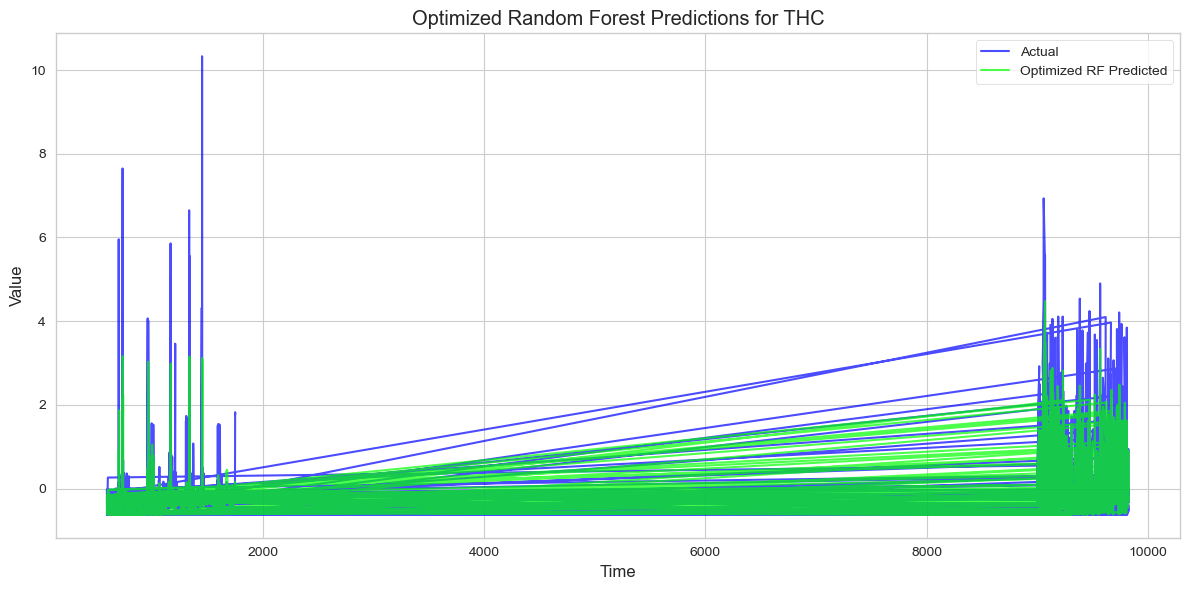

Optimizing GRU...
Best GRU configuration - Units: 64, Learning Rate: 0.001000
Best GRU validation loss: 0.9746
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Optimized GRU Performance:
MSE: 0.7684
RMSE: 0.8766
MAE: 0.5774
R2 Score: 0.0529



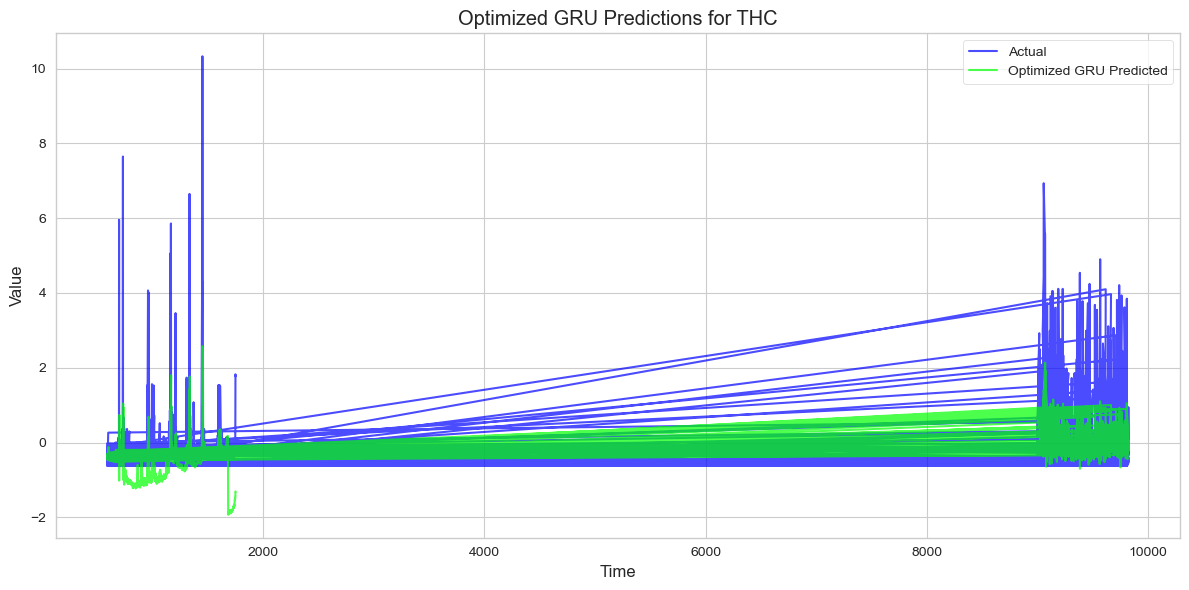

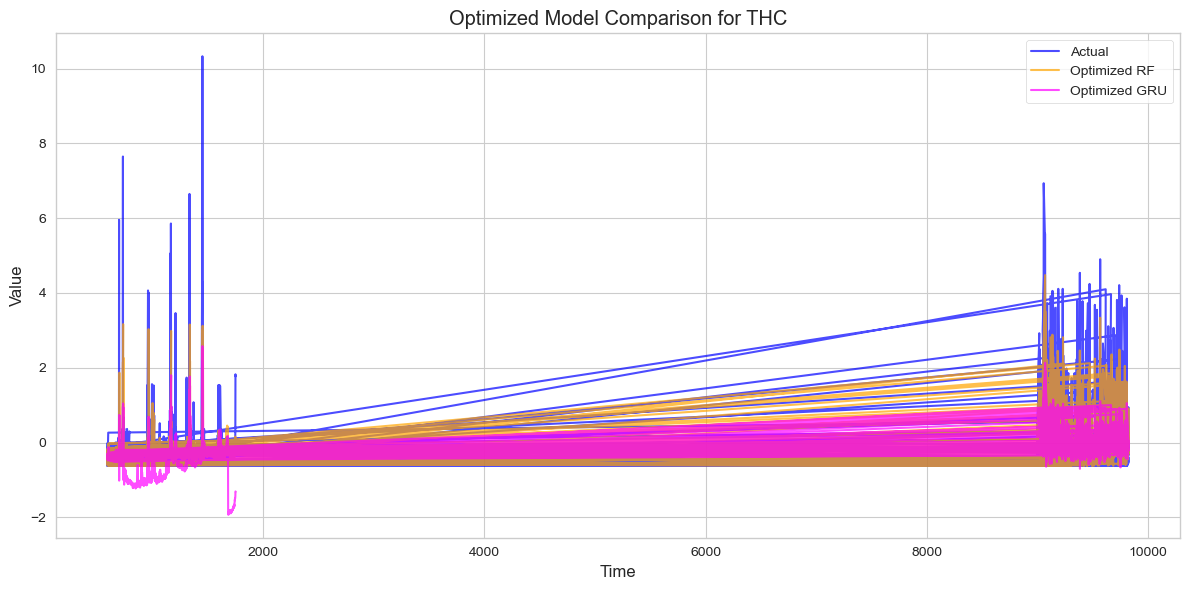


Optimizing models for EWH dataset
Optimizing Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Random Forest parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
Optimized Random Forest Performance:
MSE: 0.0189
RMSE: 0.1374
MAE: 0.0223
R2 Score: 0.9764



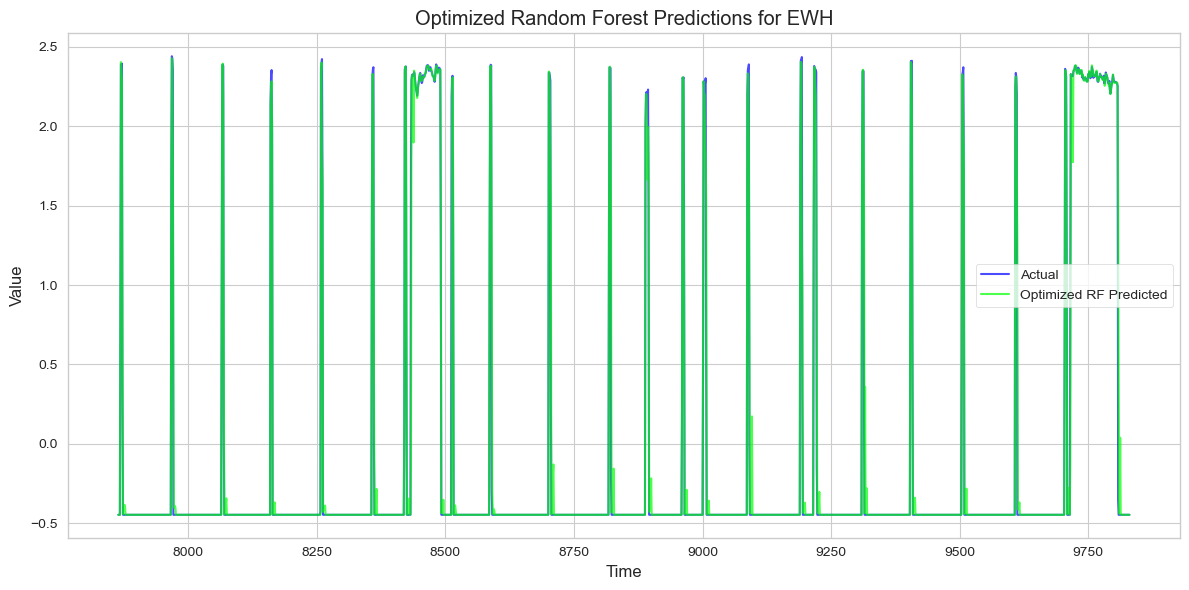

Optimizing GRU...
Best GRU configuration - Units: 32, Learning Rate: 0.010000
Best GRU validation loss: 0.0677
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Optimized GRU Performance:
MSE: 1.6832
RMSE: 1.2974
MAE: 0.8503
R2 Score: -1.1024



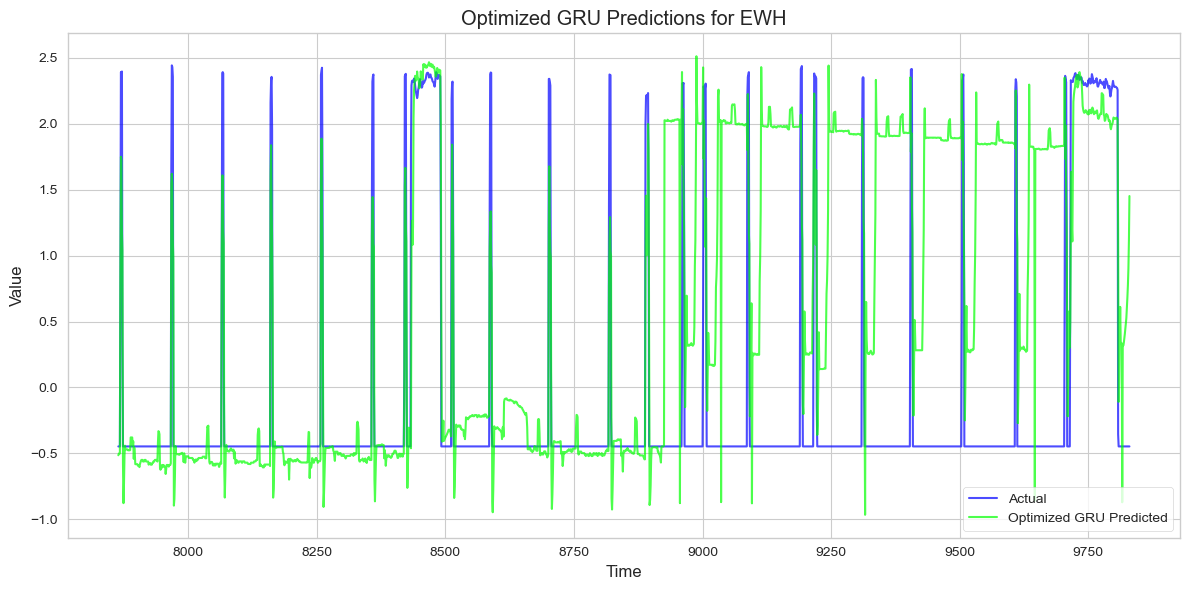

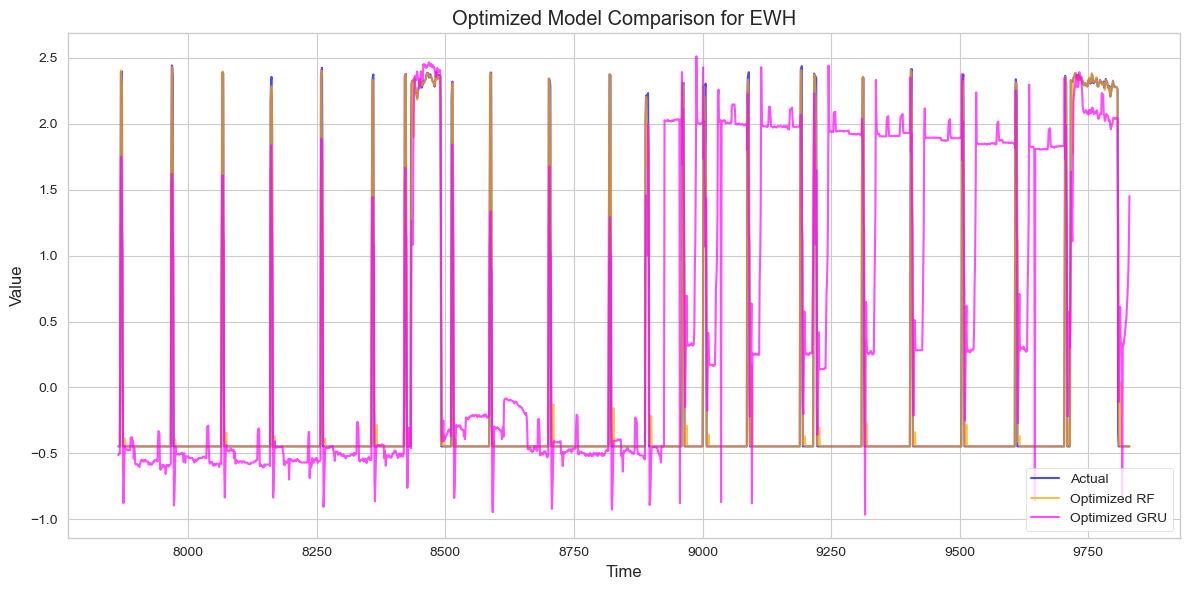


Optimizing models for DEC dataset
Optimizing Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Random Forest parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}
Optimized Random Forest Performance:
MSE: 0.0018
RMSE: 0.0427
MAE: 0.0069
R2 Score: 0.9980



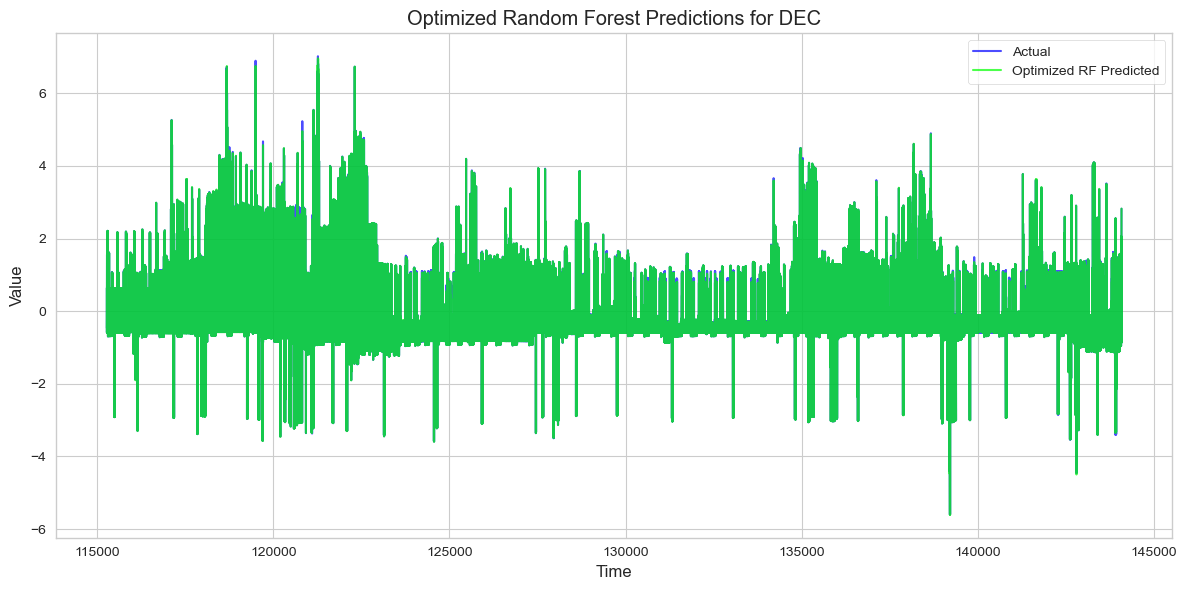

Optimizing GRU...
Best GRU configuration - Units: 32, Learning Rate: 0.001000
Best GRU validation loss: 0.0047
901/901 ━━━━━━━━━━━━━━━━━━━━ 1s 945us/step
Optimized GRU Performance:
MSE: 0.0332
RMSE: 0.1822
MAE: 0.1309
R2 Score: 0.9626



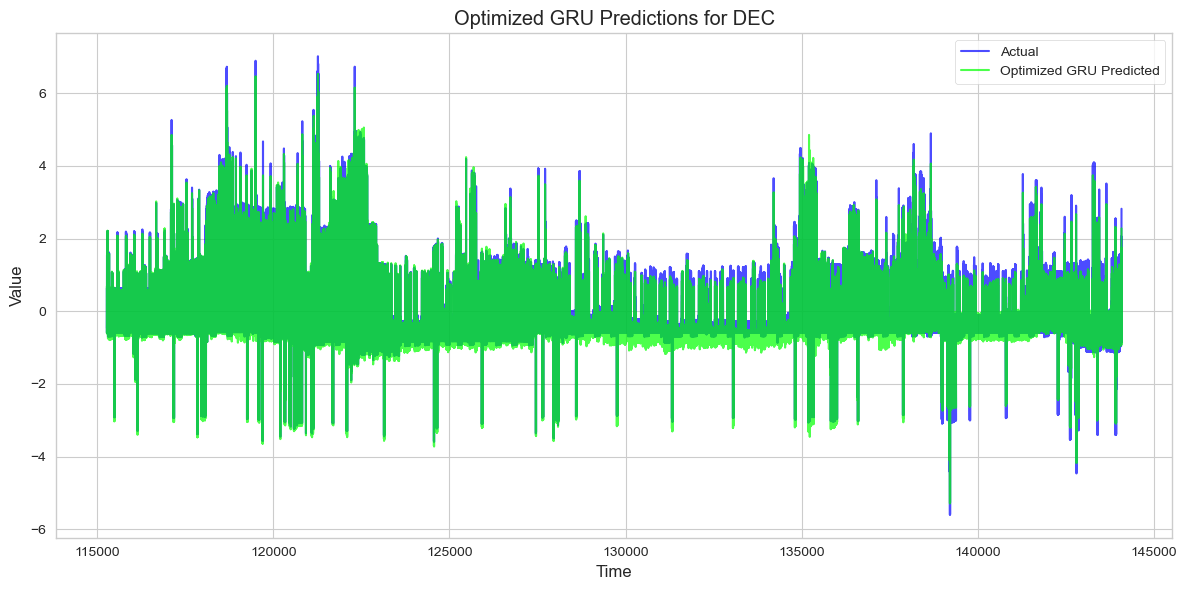

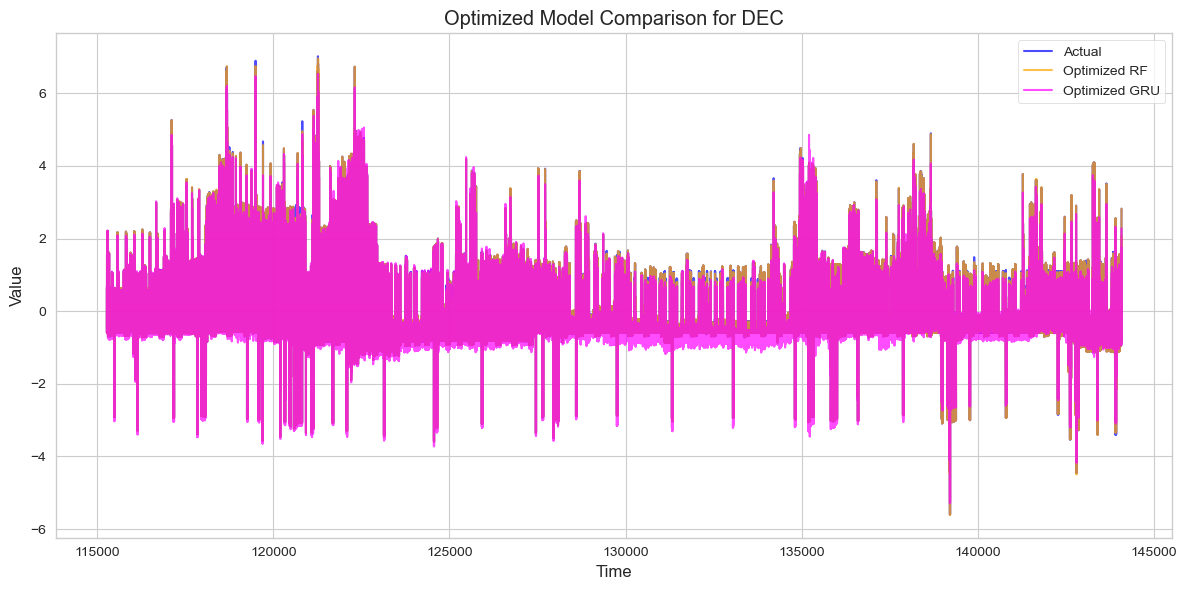


Model optimization and evaluation process completed.


In [31]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def optimize_random_forest(X_train, y_train):
    """Optimize Random Forest using RandomizedSearchCV."""
    param_dist = {
        'n_estimators': [50, 100],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    
    rf = RandomForestRegressor(random_state=42)
    tscv = TimeSeriesSplit(n_splits=3)
    
    random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                                       n_iter=10, cv=tscv, scoring='neg_mean_squared_error', 
                                       n_jobs=-1, verbose=1, random_state=42)
    random_search.fit(X_train, y_train)
    
    print("Best Random Forest parameters:", random_search.best_params_)
    return random_search.best_estimator_

def optimize_gru(X_train, y_train, X_val, y_val):
    """Optimize GRU model using a simplified manual search."""
    best_model = None
    best_val_loss = float('inf')
    
    units_options = [32, 64]
    learning_rates = [0.001, 0.01]
    
    # Convert DataFrames to numpy arrays
    X_train_array = X_train.values.astype(np.float32)
    X_val_array = X_val.values.astype(np.float32)
    y_train_array = y_train.values.astype(np.float32)
    y_val_array = y_val.values.astype(np.float32)
    
    X_train_3d = X_train_array.reshape((X_train_array.shape[0], 1, X_train_array.shape[1]))
    X_val_3d = X_val_array.reshape((X_val_array.shape[0], 1, X_val_array.shape[1]))
    
    for units in units_options:
        for lr in learning_rates:
            model = Sequential([
                GRU(units, activation='relu', input_shape=(1, X_train_array.shape[1])),
                Dense(1)
            ])
            optimizer = Adam(learning_rate=lr)
            model.compile(optimizer=optimizer, loss='mse')
            
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            
            history = model.fit(
                X_train_3d, y_train_array,
                epochs=50,
                batch_size=32,
                validation_data=(X_val_3d, y_val_array),
                callbacks=[early_stopping],
                verbose=0
            )
            
            val_loss = min(history.history['val_loss'])
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                best_lr = lr  # Store the best learning rate
    
    print(f"Best GRU configuration - Units: {best_model.layers[0].units}, "
          f"Learning Rate: {best_lr:.6f}")
    print(f"Best GRU validation loss: {best_val_loss:.4f}")
    return best_model

# Main execution with optimization
for df, name, target in zip([THC, EWH, DEC], ['THC', 'EWH', 'DEC'], ['value', 'power', 'apower']):
    print(f"\nOptimizing models for {name} dataset")
    X_train, X_test, y_train, y_test = prepare_data(df, target)
    
    # Optimize Random Forest
    print("Optimizing Random Forest...")
    best_rf = optimize_random_forest(X_train, y_train)
    rf_pred = best_rf.predict(X_test)
    evaluate_model(y_test, rf_pred, "Optimized Random Forest")
    plot_predictions(y_test, rf_pred, f'Optimized Random Forest Predictions for {name}', 'Optimized RF')
    
    # Optimize GRU
    print("Optimizing GRU...")
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
    best_gru = optimize_gru(X_train, y_train, X_val, y_val)
    
    X_test_array = X_test.values.astype(np.float32)
    X_test_3d = X_test_array.reshape((X_test_array.shape[0], 1, X_test_array.shape[1]))
    gru_pred = best_gru.predict(X_test_3d).flatten()
    evaluate_model(y_test, gru_pred, "Optimized GRU")
    plot_predictions(y_test, gru_pred, f'Optimized GRU Predictions for {name}', 'Optimized GRU')
    
    # Compare optimized models
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Actual', color='blue', alpha=0.7)
    plt.plot(y_test.index, rf_pred, label='Optimized RF', color='orange', alpha=0.7)
    plt.plot(y_test.index, gru_pred, label='Optimized GRU', color='magenta', alpha=0.7)
    plt.title(f'Optimized Model Comparison for {name}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\nModel optimization and evaluation process completed.")